In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
import os

In [43]:
def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    
    if "closed" in ride_data.columns:
        if ride_data["closed"].dtype == bool:
            ride_data["closed"] = ride_data["closed"].astype(int)
        else:
            ride_data["closed"] = ride_data["closed"].astype(bool).astype(int)
    
    if ride_data['timestamp'].duplicated().any():
        print(f"Warning: Found {ride_data['timestamp'].duplicated().sum()} duplicate timestamps. Keeping first occurrence.")
        ride_data = ride_data[~ride_data['timestamp'].duplicated(keep='first')]
    
    try:
        ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Using alternative approach to handle resampling...")
        
        ride_data['timestamp_rounded'] = ride_data['timestamp'].dt.floor('30min')
        numeric_cols = ride_data.select_dtypes(include=['number']).columns
        
        non_numeric_cols = [col for col in ride_data.columns 
                           if col not in numeric_cols and col != 'timestamp']

        agg_dict = {col: 'mean' for col in numeric_cols}
        for col in non_numeric_cols:
            agg_dict[col] = 'first'

        ride_data = ride_data.groupby('timestamp_rounded').agg(agg_dict).reset_index()
        ride_data.rename(columns={'timestamp_rounded': 'timestamp'}, inplace=True)

    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    return ride_data

In [44]:
def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:min(10, len(fully_closed_days))])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]

    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:min(10, len(zero_wait_days))])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

In [45]:
def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()

    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour

    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)

    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])

    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

In [46]:
def create_binned_time_features(df):
    """Create more granular binned time features and other relevant features."""
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    
    # Create more granular time bins (30-minute bins instead of hourly)
    # This helps with the regression to the mean problem by capturing more specific patterns
    df['hour_minute'] = df['hour'] + df['minute']/60
    hour_min_bins = [6 + i*0.5 for i in range(37)]  # From 6:00 to 24:00 in 30min intervals
    hour_min_labels = [f"{int(h)}:{int((h-int(h))*60):02d}-{int(h+0.5)}:{int((h+0.5-int(h+0.5))*60):02d}" 
                      for h in hour_min_bins[:-1]]
    
    df['time_30min_bin'] = pd.cut(
        df['hour_minute'], 
        bins=hour_min_bins, 
        labels=hour_min_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Also create 1-hour bins for comparison with the original
    hour_bins = list(range(6, 25))
    hour_bin_labels = [f"{h:02d}:00-{h+1:02d}:00" for h in range(6, 24)]
    
    df['hour_bin'] = pd.cut(
        df['hour'], 
        bins=hour_bins, 
        labels=hour_bin_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Keep original time of day bins for comparison
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 9),
        (df['hour'] >= 9) & (df['hour'] < 12),
        (df['hour'] >= 12) & (df['hour'] < 15),
        (df['hour'] >= 15) & (df['hour'] < 18),
        (df['hour'] >= 18) & (df['hour'] < 21),
        (df['hour'] >= 21) | (df['hour'] < 6)
    ]
    
    time_bins = [
        'early_morning',
        'late_morning',
        'early_afternoon',
        'late_afternoon',
        'early_evening',
        'night'
    ]
    
    df['time_of_day_bin'] = np.select(conditions, time_bins, default='other')
    
    # Add day-specific features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['day_of_month'] = df['timestamp'].dt.day
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
    
    # More detailed month and season information
    df['month'] = df['timestamp'].dt.month
    
    # Create month pairs to better capture seasonal effects
    df['month_pair'] = ((df['month'] - 1) // 2) + 1
    
    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),
        (df['month'] >= 6) & (df['month'] <= 8),
        (df['month'] >= 9) & (df['month'] <= 11),
        (df['month'] == 12) | (df['month'] <= 2)
    ]
    
    seasons = ['spring', 'summer', 'fall', 'winter']
    df['season'] = np.select(conditions, seasons, default='unknown')
    
    # Create interaction features for time and day
    df['weekend_hour'] = df['hour'] * df['is_weekend']
    
    # Add day type (weekday vs weekend)
    df['day_type'] = df['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
    
    # Add time-of-day combinations with day type
    df['day_time_combo'] = df['day_type'] + '_' + df['time_of_day_bin']
    
    # Even more granular: weekend/weekday + specific hour
    df['day_hour_combo'] = df['day_type'] + '_' + df['hour'].astype(str)
    
    # Process holiday columns
    holiday_cols = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
    existing_holiday_cols = [col for col in holiday_cols if col in df.columns]
    
    if existing_holiday_cols:
        df['is_any_holiday'] = df[existing_holiday_cols].max(axis=1)
        df['holiday_weekend'] = df['is_any_holiday'] * df['is_weekend']
    else:
        df['is_any_holiday'] = 0
        df['holiday_weekend'] = 0

    # More detailed temperature binning
    if 'temperature' in df.columns:
        bins = [0, 5, 10, 15, 20, 25, 30, 100]
        labels = ['very_cold', 'cold', 'cool', 'mild', 'warm', 'hot', 'very_hot']
        df['temp_bin'] = pd.cut(df['temperature'], bins=bins, labels=labels)
        
        # Add temperature comfort index
        df['temp_comfort'] = -((df['temperature'] - 22) ** 2)  # 22°C is assumed optimal
    
    # Rain intensity categorization
    if 'rain' in df.columns:
        df['has_rain'] = (df['rain'] > 0).astype(int)
        bins = [0, 0.001, 1, 2.5, 5, 100]  
        labels = ['none', 'light', 'moderate', 'heavy', 'extreme']
        df['rain_intensity'] = pd.cut(df['rain'], bins=bins, labels=labels)
        
        # Add feature for first rain after dry period
        df['prev_has_rain'] = df.groupby(df['timestamp'].dt.date)['has_rain'].shift(1).fillna(0)
        df['first_rain_after_dry'] = ((df['has_rain'] == 1) & (df['prev_has_rain'] == 0)).astype(int)
        
        # Weather comfort features
        if 'temperature' in df.columns:
            df['cold_rain'] = ((df['temperature'] < 15) & (df['rain'] > 0)).astype(int)
    
    # Add date column for aggregations
    df['date'] = df['timestamp'].dt.date
    
    # Add cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

In [47]:
def create_advanced_attendance_features(df):
    """Create more sophisticated attendance proxy features based on historical patterns."""
    df = df.copy()
    
    # Ensure we have a date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # 1. Create historical lag features
    # Group by date and calculate daily average wait time
    daily_avg_wait = df.groupby('date')['wait_time'].agg(['mean', 'median', 'max']).reset_index()
    daily_avg_wait.columns = ['date', 'daily_avg_wait', 'daily_median_wait', 'daily_max_wait']
    
    # Sort by date
    daily_avg_wait = daily_avg_wait.sort_values('date')
    
    # Create lagged features
    for lag in [1, 2, 3, 7, 14, 28]:
        daily_avg_wait[f'avg_wait_lag_{lag}d'] = daily_avg_wait['daily_avg_wait'].shift(lag)
        daily_avg_wait[f'max_wait_lag_{lag}d'] = daily_avg_wait['daily_max_wait'].shift(lag)
    
    # Calculate rolling averages
    for window in [3, 7, 14, 30]:
        daily_avg_wait[f'avg_wait_roll_{window}d'] = daily_avg_wait['daily_avg_wait'].rolling(window, min_periods=1).mean()
        daily_avg_wait[f'max_wait_roll_{window}d'] = daily_avg_wait['daily_max_wait'].rolling(window, min_periods=1).mean()
    
    # Merge back into the main dataframe
    df = df.merge(daily_avg_wait, on='date', how='left')
    
    # 2. Create day-of-week historical average
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    day_of_week_avg = df.groupby('day_of_week')['wait_time'].agg(['mean', 'median', 'max']).reset_index()
    day_of_week_avg.columns = ['day_of_week', 'dow_avg_wait', 'dow_median_wait', 'dow_max_wait']
    
    # Merge back to the main dataframe
    df = df.merge(day_of_week_avg, on='day_of_week', how='left')
    
    # 3. Create hour-of-day historical average
    if 'hour' not in df.columns:
        df['hour'] = df['timestamp'].dt.hour
    
    hour_avg = df.groupby('hour')['wait_time'].agg(['mean', 'median', 'max']).reset_index()
    hour_avg.columns = ['hour', 'hour_avg_wait', 'hour_median_wait', 'hour_max_wait']
    
    # Merge back
    df = df.merge(hour_avg, on='hour', how='left')
    
    # 4. Create day-of-week × hour-of-day interaction average
    day_hour_avg = df.groupby(['day_of_week', 'hour'])['wait_time'].mean().reset_index()
    day_hour_avg.columns = ['day_of_week', 'hour', 'day_hour_avg_wait']
    
    # Merge back
    df = df.merge(day_hour_avg, on=['day_of_week', 'hour'], how='left')
    
    # 5. Create month-specific day of week average
    if 'month' not in df.columns:
        df['month'] = df['timestamp'].dt.month
    
    month_day_avg = df.groupby(['month', 'day_of_week'])['wait_time'].mean().reset_index()
    month_day_avg.columns = ['month', 'day_of_week', 'month_day_avg_wait']
    
    # Merge back
    df = df.merge(month_day_avg, on=['month', 'day_of_week'], how='left')
    
    # 6. Create features for consecutive busy days
    # Sort daily avg wait times
    daily_avg_wait = daily_avg_wait.sort_values('date')
    
    # Define "busy" as above median wait time
    median_wait = daily_avg_wait['daily_avg_wait'].median()
    daily_avg_wait['is_busy_day'] = (daily_avg_wait['daily_avg_wait'] > median_wait).astype(int)
    
    # Create features for consecutive busy days
    busy_day_streak = []
    current_streak = 0
    
    for i, row in daily_avg_wait.iterrows():
        if row['is_busy_day'] == 1:
            current_streak += 1
        else:
            current_streak = 0
        busy_day_streak.append(current_streak)
    
    daily_avg_wait['busy_day_streak'] = busy_day_streak
    
    # Merge back
    df = df.merge(daily_avg_wait[['date', 'is_busy_day', 'busy_day_streak']], on='date', how='left')
    
    # 7. Same day last year (if data spans multiple years)
    df['year'] = df['timestamp'].dt.year
    df['month_day'] = df['timestamp'].dt.strftime('%m-%d')
    
    # Group by month-day across all years
    same_day_avg = df.groupby('month_day')['wait_time'].mean().reset_index()
    same_day_avg.columns = ['month_day', 'same_day_avg_wait']
    
    # Merge back
    df = df.merge(same_day_avg, on='month_day', how='left')
    
    # 8. Special day of year features
    # Day of year normalized to 0-1 range for cyclical encoding
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    
    # Fill missing values with appropriate defaults
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [48]:
def enhance_weather_features(df):
    """Create more sophisticated weather features beyond simple temperature and rain."""
    df = df.copy()
    
    # Check if we have weather data
    has_temp = 'temperature' in df.columns
    has_rain = 'rain' in df.columns
    has_wind = 'wind' in df.columns
    
    if not (has_temp or has_rain or has_wind):
        print("No weather data found in the dataframe")
        return df
    
    # Ensure we have date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # 1. Create weather change features (rate of change)
    # Group by date to get daily min, max, avg for weather metrics
    weather_daily = df.groupby('date').agg({
        'temperature': ['min', 'max', 'mean', 'std'] if has_temp else 'count',
        'rain': ['max', 'mean', 'sum'] if has_rain else 'count',
        'wind': ['max', 'mean'] if has_wind else 'count'
    })
    
    # Flatten the column names
    weather_daily.columns = ['_'.join(col).strip() for col in weather_daily.columns.values]
    
    # Calculate day-to-day changes
    if has_temp:
        weather_daily['temp_change'] = weather_daily['temperature_mean'].diff()
        weather_daily['temp_range'] = weather_daily['temperature_max'] - weather_daily['temperature_min']
    
    if has_rain:
        # Create a feature for "first rain after dry period"
        weather_daily['was_dry_yesterday'] = (weather_daily['rain_sum'].shift(1) == 0).astype(int)
        weather_daily['first_rain_after_dry'] = (
            (weather_daily['rain_sum'] > 0) & 
            (weather_daily['was_dry_yesterday'] == 1)
        ).astype(int)
    
    # Merge daily weather features back to the main dataframe
    df = df.merge(weather_daily, left_on='date', right_index=True, how='left')
    
    # 2. Create more nuanced temperature features
    if has_temp:
        # Temperature squared for non-linear effects
        df['temperature_squared'] = df['temperature'] ** 2
        
        # Comfort index (simplified version of heat index)
        # People tend to avoid parks when it's too hot or too cold
        df['temp_comfort'] = -((df['temperature'] - 22) ** 2)  # 22°C is assumed optimal
        
        # Binned temperature feel (categorical)
        bins = [-float('inf'), 5, 10, 15, 20, 25, 30, float('inf')]
        labels = ['freezing', 'very_cold', 'cold', 'cool', 'mild', 'warm', 'hot']
        df['temp_feel'] = pd.cut(df['temperature'], bins=bins, labels=labels)
    
    # 3. Create more nuanced rain features
    if has_rain:
        # Rain duration proxy (if we have consecutive hours with rain)
        df['hour'] = df['timestamp'].dt.hour
        df['previous_hour_rain'] = df.groupby('date')['rain'].shift(1).fillna(0)
        df['rain_continued'] = ((df['rain'] > 0) & (df['previous_hour_rain'] > 0)).astype(int)
        
        # Rain intensity categories (more detailed than binary rain/no rain)
        bins = [0, 0.1, 1.0, 2.5, 5.0, float('inf')]
        labels = ['none', 'drizzle', 'light', 'moderate', 'heavy']
        df['rain_intensity'] = pd.cut(df['rain'], bins=bins, labels=labels)
        
        # Interaction between rain and temperature
        if has_temp:
            # Cold rain is often more uncomfortable than warm rain
            df['cold_rain'] = ((df['temperature'] < 15) & (df['rain'] > 0)).astype(int)
    
    # 4. Create more nuanced wind features
    if has_wind:
        # Wind categories
        bins = [0, 2, 5, 8, 12, float('inf')]
        labels = ['calm', 'light', 'moderate', 'strong', 'extreme']
        df['wind_force'] = pd.cut(df['wind'], bins=bins, labels=labels)
        
        # Create wind and rain interaction
        if has_rain:
            df['rain_with_wind'] = ((df['rain'] > 0) & (df['wind'] > 5)).astype(int)
    
    # 5. Create overall weather comfort score
    weather_factors = []
    
    if has_temp:
        # Temperature factor (0-1 scale, 1 is best)
        df['temp_factor'] = 1.0 - abs(df['temperature'] - 22) / 22
        df['temp_factor'] = df['temp_factor'].clip(0, 1)
        weather_factors.append('temp_factor')
    
    if has_rain:
        # Rain factor (0-1 scale, 1 is best)
        df['rain_factor'] = 1.0 - df['rain'].clip(0, 5) / 5
        weather_factors.append('rain_factor')
    
    if has_wind:
        # Wind factor (0-1 scale, 1 is best)
        df['wind_factor'] = 1.0 - df['wind'].clip(0, 10) / 10
        weather_factors.append('wind_factor')
    
    if len(weather_factors) > 0:
        # Combined weather comfort score (0-100, higher is better)
        df['weather_comfort_score'] = df[weather_factors].mean(axis=1) * 100
    
    return df

In [49]:
def create_special_event_features(df, special_events_dates=None):
    """Add features for special events that might affect park attendance."""
    df = df.copy()
    
    # Ensure we have a date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # If no special events are provided, create some default ones
    if special_events_dates is None:
        # Define some approximate special events
        # These are just examples - in practice, you'd use actual dates
        year = df['timestamp'].dt.year.min()
        
        # Define vacation periods (approximations)
        summer_vacation = [f"{year}-07-{day:02d}" for day in range(1, 32)] + [f"{year}-08-{day:02d}" for day in range(1, 32)]
        spring_break = [f"{year}-04-{day:02d}" for day in range(10, 21)]
        winter_break = [f"{year}-12-{day:02d}" for day in range(20, 32)] + [f"{year}-01-{day:02d}" for day in range(1, 11)]
        
        # Define major holidays
        new_year = [f"{year}-01-01"]
        easter = [f"{year}-04-14"]  # Approximation
        labor_day = [f"{year}-05-01"]
        national_day = [f"{year}-10-03"]  # German Unity Day
        christmas = [f"{year}-12-24", f"{year}-12-25", f"{year}-12-26"]
        
        special_events_dates = {
            'summer_vacation': summer_vacation,
            'spring_break': spring_break,
            'winter_break': winter_break,
            'major_holiday': new_year + easter + labor_day + national_day + christmas
        }
    
    # Convert date strings to datetime.date objects
    processed_events = {}
    for event_type, dates in special_events_dates.items():
        processed_events[event_type] = [pd.to_datetime(date).date() for date in dates]
    
    # Create indicator features for each event type
    for event_type, dates in processed_events.items():
        feature_name = f'is_{event_type}'
        df[feature_name] = df['date'].isin(dates).astype(int)
        
        # Create features for days before and after events
        df[f'{feature_name}_tomorrow'] = df['date'].apply(
            lambda x: (x + timedelta(days=1)) in dates).astype(int)
        df[f'{feature_name}_yesterday'] = df['date'].apply(
            lambda x: (x - timedelta(days=1)) in dates).astype(int)
    
    # Create a combined 'special_day' feature
    df['is_any_special_event'] = 0
    for event_type in processed_events:
        df['is_any_special_event'] = np.maximum(df['is_any_special_event'], 
                                               df[f'is_{event_type}'])
    
    return df

In [50]:
def prepare_features_for_model(df):
    """Prepare enhanced features for the model with proper NaN handling."""
    print("Starting feature preparation...")
    print(f"Input dataframe shape: {df.shape}")
    
    # First, check for NaN values in the target variable
    if 'wait_time' in df.columns:
        nan_count = df['wait_time'].isna().sum()
        if nan_count > 0:
            print(f"Warning: Found {nan_count} NaN values in wait_time. Dropping these rows.")
            df = df.dropna(subset=['wait_time'])
            print(f"Dataframe shape after dropping NaN wait times: {df.shape}")
    
    # Define categorical and numerical features
    categorical_features = [
        'hour_bin', 
        'time_of_day_bin', 
        'season', 
        'day_of_week', 
        'day_type'
    ]
    
    # Add time bin features if they exist
    if 'time_30min_bin' in df.columns:
        categorical_features.append('time_30min_bin')
    if 'day_time_combo' in df.columns:
        categorical_features.append('day_time_combo')
    if 'day_hour_combo' in df.columns:
        categorical_features.append('day_hour_combo')
    
    # Add weather categorical features if available
    if 'temp_bin' in df.columns:
        categorical_features.append('temp_bin')
    if 'temp_feel' in df.columns:
        categorical_features.append('temp_feel')
    if 'rain_intensity' in df.columns:
        categorical_features.append('rain_intensity')
    if 'wind_force' in df.columns:
        categorical_features.append('wind_force')

    # Define numerical features with base features
    numerical_features = [
        'is_weekend', 
        'hour',
        'day_of_month',
        'week_of_year'
    ]
    
    # Add holiday features if they exist
    if 'is_any_holiday' in df.columns:
        numerical_features.append('is_any_holiday')
    if 'holiday_weekend' in df.columns:
        numerical_features.append('holiday_weekend')
    
    # Add more granular time features if they exist
    if 'minute' in df.columns:
        numerical_features.append('minute')
    if 'hour_minute' in df.columns:
        numerical_features.append('hour_minute')
    
    # Add cyclical features if they exist
    cyclical_features = [
        'day_of_year_sin', 'day_of_year_cos',
        'hour_sin', 'hour_cos',
        'day_of_week_sin', 'day_of_week_cos',
        'month_sin', 'month_cos'
    ]
    numerical_features.extend([f for f in cyclical_features if f in df.columns])
    
    # Filter to only include columns that exist in the dataframe
    categorical_features = [col for col in categorical_features if col in df.columns]
    numerical_features = [col for col in numerical_features if col in df.columns]
    
    # Add interaction features
    if 'weekend_hour' in df.columns:
        numerical_features.append('weekend_hour')
    
    # Add attendance features
    attendance_features = [
        'daily_avg_wait',
        'daily_median_wait',
        'daily_max_wait',
        'dow_avg_wait',
        'hour_avg_wait',
        'day_hour_avg_wait',
        'month_day_avg_wait',
        'same_day_avg_wait'
    ]
    numerical_features.extend([f for f in attendance_features if f in df.columns])
    
    # Add lag and rolling features if they exist
    lag_features = [col for col in df.columns if 'lag_' in col]
    numerical_features.extend([f for f in lag_features if f in df.columns])
    
    roll_features = [col for col in df.columns if 'roll_' in col]
    numerical_features.extend([f for f in roll_features if f in df.columns])
    
    # Add streak features
    if 'busy_day_streak' in df.columns:
        numerical_features.append('busy_day_streak')
    
    # Add special event features
    event_features = [col for col in df.columns if 'is_' in col]
    numerical_features.extend([f for f in event_features if f in df.columns])
    
    # Add weather features if available
    if 'temperature' in df.columns:
        numerical_features.append('temperature')
    if 'temperature_squared' in df.columns:
        numerical_features.append('temperature_squared')
    if 'temp_comfort' in df.columns:
        numerical_features.append('temp_comfort')
    if 'temp_factor' in df.columns:
        numerical_features.append('temp_factor')
    
    # Add other weather features if they exist
    weather_features = [
        'temperature_mean', 'temperature_max', 'temperature_min', 'temp_range',
        'temp_change', 'rain', 'has_rain', 'rain_factor', 'rain_sum', 'rain_mean',
        'rain_max', 'cold_rain', 'wind', 'wind_factor', 'wind_mean', 'wind_max',
        'closed', 'weather_comfort_score'
    ]
    numerical_features.extend([f for f in weather_features if f in df.columns])
    
    # Create feature dataframe - only include columns that exist
    all_features = list(set(categorical_features + numerical_features))  # Remove duplicates
    print(f"Total features selected: {len(all_features)}")
    
    # Check if features exist in dataframe
    missing_features = [col for col in all_features if col not in df.columns]
    if missing_features:
        print(f"Warning: These features are missing from the dataframe: {missing_features}")
        all_features = [col for col in all_features if col in df.columns]
    
    feature_df = df[all_features].copy()
    
    # Check for NaN values
    null_counts = feature_df.isnull().sum()
    total_nulls = null_counts.sum()
    
    if total_nulls > 0:
        print(f"Warning: Found {total_nulls} missing values in features")
        
        # Features with the most missing values (top 5)
        print("Features with most missing values:")
        print(null_counts[null_counts > 0].sort_values(ascending=False).head(5))
        
        # Fill missing values in numerical features
        for col in numerical_features:
            if col in feature_df.columns:
                col_null_count = feature_df[col].isnull().sum()
                if col_null_count > 0:
                    print(f"Filling {col_null_count} missing values in '{col}'")
                    feature_df[col] = feature_df[col].fillna(feature_df[col].median())
        
        # Fill missing values in categorical features
        for col in categorical_features:
            if col in feature_df.columns:
                col_null_count = feature_df[col].isnull().sum()
                if col_null_count > 0:
                    print(f"Filling {col_null_count} missing values in '{col}'")
                    mode_value = feature_df[col].mode()
                    if len(mode_value) > 0:
                        feature_df[col] = feature_df[col].fillna(mode_value[0])
                    else:
                        print(f"Warning: Could not find mode for '{col}'. Dropping column.")
                        feature_df = feature_df.drop(columns=[col])
                        if col in categorical_features:
                            categorical_features.remove(col)
    
    # Final check for any remaining NaN values
    remaining_nulls = feature_df.isnull().sum().sum()
    if remaining_nulls > 0:
        print(f"Warning: {remaining_nulls} NaN values remain after filling. Dropping these rows.")
        feature_df = feature_df.dropna()
        print(f"Final feature dataframe shape: {feature_df.shape}")
    
    return feature_df, categorical_features, numerical_features

In [51]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PowerTransformer


def build_and_train_nonlinear_model(X_train, y_train, categorical_features, numerical_features):
    """Build and train a model with non-linear transformations of the target variable."""
    # Apply a power transformation to the target variable
    # This helps with the issue of under-predicting high values and over-predicting low values
    pt = PowerTransformer(method='yeo-johnson')
    
    # Add small constant to avoid issues with zero values
    y_train_transformed = pt.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Build the model using the transformed target
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    # Use a Ridge regression model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ])

    # Train on the transformed target
    model.fit(X_train, y_train_transformed)
    
    # Return both the model and the transformer for later use
    return model, pt

In [52]:
def build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features):
    """Build and train a gradient boosting model for wait time prediction."""
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    # Use GradientBoostingRegressor which handles non-linearity well
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    model.fit(X_train, y_train)
    return model

In [53]:
def train_ensemble_model(X_train, y_train, categorical_features, numerical_features):
    """Train an ensemble of different models and combine their predictions."""
    # Create preprocessor
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )
    
    # Create preprocessed features once to avoid redundant computation
    X_train_processed = preprocessor.fit_transform(X_train)
    
    # Create multiple base models
    linear_model = Ridge(alpha=1.0)
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    gb_model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    # Train each model
    print("Training linear model...")
    linear_model.fit(X_train_processed, y_train)
    
    print("Training random forest model...")
    rf_model.fit(X_train_processed, y_train)
    
    print("Training gradient boosting model...")
    gb_model.fit(X_train_processed, y_train)
    
    # Create voting ensemble
    ensemble = VotingRegressor([
        ('linear', linear_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ])
    
    print("Training ensemble model...")
    ensemble.fit(X_train_processed, y_train)
    
    # Create a final pipeline that includes preprocessing
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('ensemble', ensemble)
    ])
    
    return final_model, {'linear': linear_model, 'rf': rf_model, 'gb': gb_model, 'ensemble': ensemble}

In [54]:
def build_peak_correction_model(X_train, y_train, y_pred_train, categorical_features, numerical_features):
    """
    Build a secondary model to correct errors in high/low wait time predictions.
    This is especially useful for improving predictions at the extremes.
    """
    # Calculate primary model errors
    errors = y_train - y_pred_train
    
    # Add the primary model's prediction as a feature
    X_train_with_pred = X_train.copy()
    X_train_with_pred['primary_prediction'] = y_pred_train
    
    # Add error indicator features
    X_train_with_pred['is_low_wait'] = (y_pred_train < 10).astype(int)
    X_train_with_pred['is_high_wait'] = (y_pred_train > 40).astype(int)
    
    # Create quartile indicators based on primary prediction
    quartiles = pd.qcut(y_pred_train, 4, labels=False)
    for i in range(4):
        X_train_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
    
    # Add the prediction to the numerical features
    numerical_features_with_pred = numerical_features + ['primary_prediction', 'is_low_wait', 'is_high_wait']
    numerical_features_with_pred.extend([f'quartile_{i}' for i in range(4)])
    
    # Build correction model to predict the errors
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features_with_pred)
        ]
    )

    # Use GradientBoostingRegressor for the correction model
    correction_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    # Train to predict the errors
    correction_model.fit(X_train_with_pred, errors)
    
    return correction_model

In [55]:
def apply_correction_model(primary_model, correction_model, X_test, y_test=None):
    """
    Apply the correction model to improve predictions.
    """
    # Get predictions from primary model
    y_pred_primary = primary_model.predict(X_test)
    
    # Ensure predictions are non-negative
    y_pred_primary = np.maximum(y_pred_primary, 0)
    
    # Create features for correction model
    X_test_with_pred = X_test.copy()
    X_test_with_pred['primary_prediction'] = y_pred_primary
    
    # Add error indicator features
    X_test_with_pred['is_low_wait'] = (y_pred_primary < 10).astype(int)
    X_test_with_pred['is_high_wait'] = (y_pred_primary > 40).astype(int)
    
    # Create quartile indicators based on primary prediction
    quartiles = pd.qcut(y_pred_primary, 4, labels=False)
    for i in range(4):
        X_test_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
    
    # Predict the errors
    predicted_errors = correction_model.predict(X_test_with_pred)
    
    # Apply corrections
    y_pred_corrected = y_pred_primary + predicted_errors
    
    # Ensure final predictions are non-negative
    y_pred_corrected = np.maximum(y_pred_corrected, 0)
    
    # Evaluate if y_test is provided
    if y_test is not None:
        # Evaluate primary model
        mae_primary = mean_absolute_error(y_test, y_pred_primary)
        rmse_primary = np.sqrt(mean_squared_error(y_test, y_pred_primary))
        r2_primary = r2_score(y_test, y_pred_primary)
        
        # Calculate MAPE for primary model
        epsilon = 1e-8
        abs_pct_errors_primary = np.abs(y_test - y_pred_primary) / (np.abs(y_test) + epsilon)
        non_zero_mask = y_test > 0
        mape_primary = np.mean(abs_pct_errors_primary[non_zero_mask]) * 100
        
        # Evaluate corrected model
        mae_corrected = mean_absolute_error(y_test, y_pred_corrected)
        rmse_corrected = np.sqrt(mean_squared_error(y_test, y_pred_corrected))
        r2_corrected = r2_score(y_test, y_pred_corrected)
        
        # Calculate MAPE for corrected model
        abs_pct_errors_corrected = np.abs(y_test - y_pred_corrected) / (np.abs(y_test) + epsilon)
        mape_corrected = np.mean(abs_pct_errors_corrected[non_zero_mask]) * 100
        
        print("Primary Model Metrics:")
        print(f"MAE: {mae_primary:.2f}, RMSE: {rmse_primary:.2f}, R²: {r2_primary:.4f}, MAPE: {mape_primary:.2f}%")
        
        print("\nCorrected Model Metrics:")
        print(f"MAE: {mae_corrected:.2f}, RMSE: {rmse_corrected:.2f}, R²: {r2_corrected:.4f}, MAPE: {mape_corrected:.2f}%")
        
        print(f"\nImprovement:")
        print(f"MAE: {mae_primary - mae_corrected:.2f} ({(mae_primary - mae_corrected) / mae_primary * 100:.2f}%)")
        print(f"RMSE: {rmse_primary - rmse_corrected:.2f} ({(rmse_primary - rmse_corrected) / rmse_primary * 100:.2f}%)")
        print(f"R²: {r2_corrected - r2_primary:.4f} ({(r2_corrected - r2_primary) / max(0.0001, abs(r2_primary)) * 100:.2f}%)")
        print(f"MAPE: {mape_primary - mape_corrected:.2f}% ({(mape_primary - mape_corrected) / mape_primary * 100:.2f}%)")
        
        # Compare predictions at different ranges
        low_wait_mask = y_test < 10
        high_wait_mask = y_test > 40
        
        if np.sum(low_wait_mask) > 0:
            mae_low_primary = mean_absolute_error(y_test[low_wait_mask], y_pred_primary[low_wait_mask])
            mae_low_corrected = mean_absolute_error(y_test[low_wait_mask], y_pred_corrected[low_wait_mask])
            print(f"\nLow Wait (<10 min) MAE: {mae_low_primary:.2f} -> {mae_low_corrected:.2f} ({(mae_low_primary - mae_low_corrected) / mae_low_primary * 100:.2f}% improvement)")
        
        if np.sum(high_wait_mask) > 0:
            mae_high_primary = mean_absolute_error(y_test[high_wait_mask], y_pred_primary[high_wait_mask])
            mae_high_corrected = mean_absolute_error(y_test[high_wait_mask], y_pred_corrected[high_wait_mask])
            print(f"High Wait (>40 min) MAE: {mae_high_primary:.2f} -> {mae_high_corrected:.2f} ({(mae_high_primary - mae_high_corrected) / mae_high_primary * 100:.2f}% improvement)")
        
        return y_pred_corrected, {
            'primary': {
                'mae': mae_primary,
                'rmse': rmse_primary,
                'r2': r2_primary,
                'mape': mape_primary
            },
            'corrected': {
                'mae': mae_corrected,
                'rmse': rmse_corrected,
                'r2': r2_corrected,
                'mape': mape_corrected
            }
        }
    
    return y_pred_corrected

In [56]:
def evaluate_model(model, X_test, y_test, feature_names=None, return_predictions=True, transformer=None):
    """Evaluate the model and print coefficients."""
    # Get raw predictions
    y_pred_raw = model.predict(X_test)
    
    # Apply inverse transform if a transformer is provided
    if transformer is not None:
        y_pred_raw = transformer.inverse_transform(y_pred_raw.reshape(-1, 1)).ravel()
    
    # Clip predictions at 0 to prevent negative wait times
    y_pred = np.maximum(y_pred_raw, 0)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
    print(f"R² Score: {r2:.4f}")

    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Evaluate model performance at different wait time ranges
    low_wait_mask = y_test < 10
    medium_wait_mask = (y_test >= 10) & (y_test <= 40)
    high_wait_mask = y_test > 40
    
    if np.sum(low_wait_mask) > 0:
        mae_low = mean_absolute_error(y_test[low_wait_mask], y_pred[low_wait_mask])
        print(f"MAE for low wait times (<10 min): {mae_low:.2f} minutes")
    
    if np.sum(medium_wait_mask) > 0:
        mae_medium = mean_absolute_error(y_test[medium_wait_mask], y_pred[medium_wait_mask])
        print(f"MAE for medium wait times (10-40 min): {mae_medium:.2f} minutes")
    
    if np.sum(high_wait_mask) > 0:
        mae_high = mean_absolute_error(y_test[high_wait_mask], y_pred[high_wait_mask])
        print(f"MAE for high wait times (>40 min): {mae_high:.2f} minutes")

    if feature_names is not None:
        print("\nFeature Importance (Coefficients):")
        try:
            regressor = model.named_steps['regressor']
            
            # For linear models
            if hasattr(regressor, 'coef_'):
                preprocessor = model.named_steps['preprocessor']
                
                try:
                    # For newer scikit-learn versions
                    feature_names = preprocessor.get_feature_names_out()
                except:
                    # For older scikit-learn versions
                    cat_cols = preprocessor.transformers_[0][2]
                    num_cols = preprocessor.transformers_[1][2]
                    
                    # Get one-hot encoded column names
                    cat_features = []
                    for i, col in enumerate(cat_cols):
                        categories = preprocessor.transformers_[0][1].named_steps['onehot'].categories_[i]
                        for category in categories:
                            cat_features.append(f"{col}_{category}")
                    
                    feature_names = np.concatenate([cat_features, num_cols])
                
                coefficients = pd.DataFrame(
                    regressor.coef_,
                    index=feature_names,
                    columns=['Coefficient']
                ).sort_values('Coefficient', ascending=False)
                
                print("\nTop 10 Positive Coefficients:")
                print(coefficients.head(10))
                
                print("\nTop 10 Negative Coefficients:")
                print(coefficients.tail(10))
            
            # For tree-based models
            elif hasattr(regressor, 'feature_importances_'):
                preprocessor = model.named_steps['preprocessor']
                
                try:
                    # For newer scikit-learn versions
                    feature_names = preprocessor.get_feature_names_out()
                except:
                    # For older scikit-learn versions
                    cat_cols = preprocessor.transformers_[0][2]
                    num_cols = preprocessor.transformers_[1][2]
                    
                    # Get one-hot encoded column names
                    cat_features = []
                    for i, col in enumerate(cat_cols):
                        categories = preprocessor.transformers_[0][1].named_steps['onehot'].categories_[i]
                        for category in categories:
                            cat_features.append(f"{col}_{category}")
                    
                    feature_names = np.concatenate([cat_features, num_cols])
                
                feature_importance = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': regressor.feature_importances_
                }).sort_values('Importance', ascending=False)
                
                print("\nTop 20 Important Features:")
                print(feature_importance.head(20))
        except Exception as e:
            print(f"Could not print feature importance: {e}")
    
    if return_predictions:
        return mae, rmse, r2, mape, y_pred
    else:
        return mae, rmse, r2, mape

In [57]:
def visualize_results(y_test, y_pred, ride_data_test, title_suffix=""):
    """Visualize the prediction results."""
    # Make sure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_pred - y_test,
        'Timestamp': ride_data_test['timestamp'].values
    })

    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    axes[0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    axes[0].plot([0, max_val], [0, max_val], 'r--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title(f'Actual vs Predicted Wait Times {title_suffix}')
    axes[0].grid(True, linestyle=':')

    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    results_df = results_df.sort_values('Timestamp')
    axes[1].plot(results_df['Timestamp'], results_df['Actual'], label='Actual', alpha=0.7)
    axes[1].plot(results_df['Timestamp'], results_df['Predicted'], label='Predicted', alpha=0.7)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Wait Time (minutes)')
    axes[1].set_title(f'Actual vs Predicted Wait Times Over Time {title_suffix}')
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    # Add detailed error analysis by wait time range
    plt.figure(figsize=(10, 6))
    
    # Create wait time bins
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    results_df['wait_bin'] = pd.cut(results_df['Actual'], bins=bins, labels=labels)
    
    # Calculate metrics for each bin
    bin_metrics = results_df.groupby('wait_bin').agg({
        'Error': ['mean', 'std'],
        'Actual': 'count'
    })
    
    bin_metrics.columns = ['Mean Error', 'Std Error', 'Count']
    bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())
    
    # Plot mean absolute error by wait time range
    plt.bar(bin_metrics.index, bin_metrics['Abs Mean Error'], alpha=0.7)
    plt.xlabel('Actual Wait Time Range (minutes)')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title(f'Error by Wait Time Range {title_suffix}')
    
    # Add count labels
    for i, count in enumerate(bin_metrics['Count']):
        plt.text(i, bin_metrics['Abs Mean Error'].iloc[i] + 0.5, f"n={count}", 
                 ha='center', va='bottom', fontsize=8)
    
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    # Hour of day analysis
    if 'hour' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['hour'] = ride_data_test['timestamp'].dt.hour

    if 'hour' in ride_data_test.columns:
        results_df['hour'] = ride_data_test['hour'].values

        hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())

        # Plot hourly MAE
        plt.figure(figsize=(12, 6))
        hourly_abs_errors.plot(kind='bar')
        plt.xlabel('Hour of Day')
        plt.ylabel('Mean Absolute Error (minutes)')
        plt.title(f'Mean Absolute Error by Hour of Day {title_suffix}')
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    # Day of week analysis
    if 'day_of_week' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['day_of_week'] = ride_data_test['timestamp'].dt.dayofweek

    if 'day_of_week' in ride_data_test.columns:
        results_df['day'] = ride_data_test['day_of_week'].values
        daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())

        # Plot daily MAE
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plt.figure(figsize=(12, 6))
        daily_abs_errors.plot(kind='bar')
        plt.xlabel('Day of Week')
        plt.ylabel('Mean Absolute Error (minutes)')
        plt.title(f'Mean Absolute Error by Day of Week {title_suffix}')
        plt.xticks(range(len(days)), days)
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    return results_df

In [58]:
def run_optimal_wait_time_prediction(file_path, ride_name, test_year=2023, special_events=None):
    """
    Run the optimized wait time prediction pipeline with all improvements.
    
    Parameters:
    -----------
    file_path : str
        Path to the parquet file with ride data
    ride_name : str
        Name of the ride to analyze
    test_year : int
        Year to use for testing (data from earlier years will be used for training)
    special_events : dict, optional
        Dictionary with event types as keys and lists of dates as values
    """
    print(f"===== Running Optimized Wait Time Prediction for {ride_name} =====")
    
    # Step 1: Load and preprocess data
    print("\n----- Step 1: Loading and preprocessing data -----")
    ride_data = load_ride_data(file_path, ride_name)
    print(f"Loaded data shape: {ride_data.shape}")
    
    ride_data = remove_closed_and_zero_wait_days(ride_data)
    print(f"Data shape after removing closed and zero wait days: {ride_data.shape}")
    
    ride_data = filter_to_operating_hours(ride_data)
    print(f"Data shape after filtering to operating hours: {ride_data.shape}")
    
    # Step 2: Feature Engineering
    print("\n----- Step 2: Creating advanced features -----")
    ride_data = create_binned_time_features(ride_data)
    print("Created time-based features")
    
    ride_data = create_advanced_attendance_features(ride_data)
    print("Created attendance features")
    
    ride_data = enhance_weather_features(ride_data)
    print("Enhanced weather features")
    
    ride_data = create_special_event_features(ride_data, special_events_dates=special_events)
    print("Created special event features")
    
    # Step 3: Prepare features for modeling
    print("\n----- Step 3: Preparing features for modeling -----")
    feature_df, categorical_features, numerical_features = prepare_features_for_model(ride_data)
    print(f"Final feature dataframe shape: {feature_df.shape}")
    print(f"Number of categorical features: {len(categorical_features)}")
    print(f"Number of numerical features: {len(numerical_features)}")
    
    # Step 4: Split data into train and test sets
    print("\n----- Step 4: Splitting data into train and test sets -----")
    # Find the target variable
    y = ride_data['wait_time'].values
    
    # Split based on year
    train_mask = ride_data['timestamp'].dt.year < test_year
    test_mask = ride_data['timestamp'].dt.year == test_year
    
    X_train = feature_df[train_mask]
    y_train = y[train_mask]
    X_test = feature_df[test_mask]
    y_test = y[test_mask]
    ride_data_test = ride_data[test_mask]
    
    print(f"Training data: {X_train.shape[0]} samples")
    print(f"Test data: {X_test.shape[0]} samples")
    
    # Step 5: Train and evaluate baseline model (with feature improvements)
    print("\n----- Step 5: Training baseline model with improved features -----")
    model_baseline = build_and_train_nonlinear_model(X_train, y_train, categorical_features, numerical_features)
    model, pt = model_baseline
    
    print("\nBaseline Model Evaluation:")
    mae, rmse, r2, mape, y_pred_baseline = evaluate_model(model, X_test, y_test, transformer=pt)
    
    print("\nVisualizing baseline model results:")
    visualize_results(y_test, y_pred_baseline, ride_data_test, title_suffix="(Baseline with Improved Features)")
    
    # Step 6: Train gradient boosting model
    print("\n----- Step 6: Training gradient boosting model -----")
    gb_model = build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features)
    
    print("\nGradient Boosting Model Evaluation:")
    mae, rmse, r2, mape, y_pred_gb = evaluate_model(gb_model, X_test, y_test)
    
    print("\nVisualizing gradient boosting model results:")
    visualize_results(y_test, y_pred_gb, ride_data_test, title_suffix="(Gradient Boosting)")
    
    # Step 7: Apply peak correction model
    print("\n----- Step 7: Creating and applying peak correction model -----")
    # Train correction model using gradient boosting predictions on training data
    y_pred_train_gb = gb_model.predict(X_train)
    correction_model = build_peak_correction_model(X_train, y_train, y_pred_train_gb, categorical_features, numerical_features)
    
    # Apply correction to test predictions
    print("\nApplying correction model to gradient boosting predictions:")
    y_pred_corrected, metrics = apply_correction_model(gb_model, correction_model, X_test, y_test)
    
    print("\nVisualizing corrected model results:")
    visualize_results(y_test, y_pred_corrected, ride_data_test, title_suffix="(Corrected Model)")
    
    # Step 8: Create ensemble model for comprehensive approach
    print("\n----- Step 8: Creating ensemble model -----")
    ensemble_model, base_models = train_ensemble_model(X_train, y_train, categorical_features, numerical_features)
    
    print("\nEnsemble Model Evaluation:")
    mae, rmse, r2, mape, y_pred_ensemble = evaluate_model(ensemble_model, X_test, y_test)
    
    print("\nVisualizing ensemble model results:")
    visualize_results(y_test, y_pred_ensemble, ride_data_test, title_suffix="(Ensemble Model)")
    
    # Step 9: Compare all models
    print("\n----- Step 9: Comparing all models -----")
    results_comparison = pd.DataFrame({
        'Baseline': {
            'MAE': mae_baseline,
            'RMSE': rmse_baseline,
            'R²': r2_baseline,
            'MAPE': mape_baseline
        },
        'Gradient Boosting': {
            'MAE': metrics['primary']['mae'],
            'RMSE': metrics['primary']['rmse'],
            'R²': metrics['primary']['r2'],
            'MAPE': metrics['primary']['mape']
        },
        'Corrected': {
            'MAE': metrics['corrected']['mae'],
            'RMSE': metrics['corrected']['rmse'],
            'R²': metrics['corrected']['r2'],
            'MAPE': metrics['corrected']['mape']
        },
        'Ensemble': {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'MAPE': mape
        }
    }).T
    
    print("\nModel Comparison:")
    print(results_comparison)
    
    # Create visualizations to compare models
    plt.figure(figsize=(12, 8))
    
    # Plot MAE comparison
    plt.subplot(2, 2, 1)
    plt.bar(results_comparison.index, results_comparison['MAE'])
    plt.title('MAE Comparison')
    plt.ylabel('MAE (minutes)')
    plt.xticks(rotation=45)
    
    # Plot RMSE comparison
    plt.subplot(2, 2, 2)
    plt.bar(results_comparison.index, results_comparison['RMSE'])
    plt.title('RMSE Comparison')
    plt.ylabel('RMSE (minutes)')
    plt.xticks(rotation=45)
    
    # Plot R² comparison
    plt.subplot(2, 2, 3)
    plt.bar(results_comparison.index, results_comparison['R²'])
    plt.title('R² Comparison')
    plt.ylabel('R²')
    plt.xticks(rotation=45)
    
    # Plot MAPE comparison
    plt.subplot(2, 2, 4)
    plt.bar(results_comparison.index, results_comparison['MAPE'])
    plt.title('MAPE Comparison')
    plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Return the best model and its predictions
    best_model_idx = results_comparison['MAE'].idxmin()
    print(f"\nBest model based on MAE: {best_model_idx}")
    
    if best_model_idx == 'Corrected':
        return {
            'primary_model': gb_model,
            'correction_model': correction_model,
            'best_predictions': y_pred_corrected,
            'all_models': {
                'baseline': model_baseline,
                'gradient_boosting': gb_model,
                'ensemble': ensemble_model
            },
            'results_comparison': results_comparison
        }
    elif best_model_idx == 'Ensemble':
        return {
            'best_model': ensemble_model,
            'best_predictions': y_pred_ensemble,
            'all_models': {
                'baseline': model_baseline,
                'gradient_boosting': gb_model,
                'correction': (gb_model, correction_model)
            },
            'results_comparison': results_comparison
        }
    elif best_model_idx == 'Gradient Boosting':
        return {
            'best_model': gb_model,
            'best_predictions': y_pred_gb,
            'all_models': {
                'baseline': model_baseline,
                'ensemble': ensemble_model,
                'correction': (gb_model, correction_model)
            },
            'results_comparison': results_comparison
        }
    else:
        return {
            'best_model': model_baseline,
            'best_predictions': y_pred_baseline,
            'all_models': {
                'gradient_boosting': gb_model,
                'ensemble': ensemble_model,
                'correction': (gb_model, correction_model)
            },
            'results_comparison': results_comparison
        }



ANALYZING RIDE: SILVER STAR

===== Running Optimized Wait Time Prediction for silver star =====

----- Step 1: Loading and preprocessing data -----
Loaded data shape: (103081, 10)
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 82
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')
Data shape after removing closed and zero wait days: (85561, 10)
Data shape after filtering to operating hours: (30240, 10)

----- Step 2: Creating advanced features -----
Created time-based features
Created attendance features
Enhanced weather features
Created special event features

----- Step 3: Preparing features for modeling ---

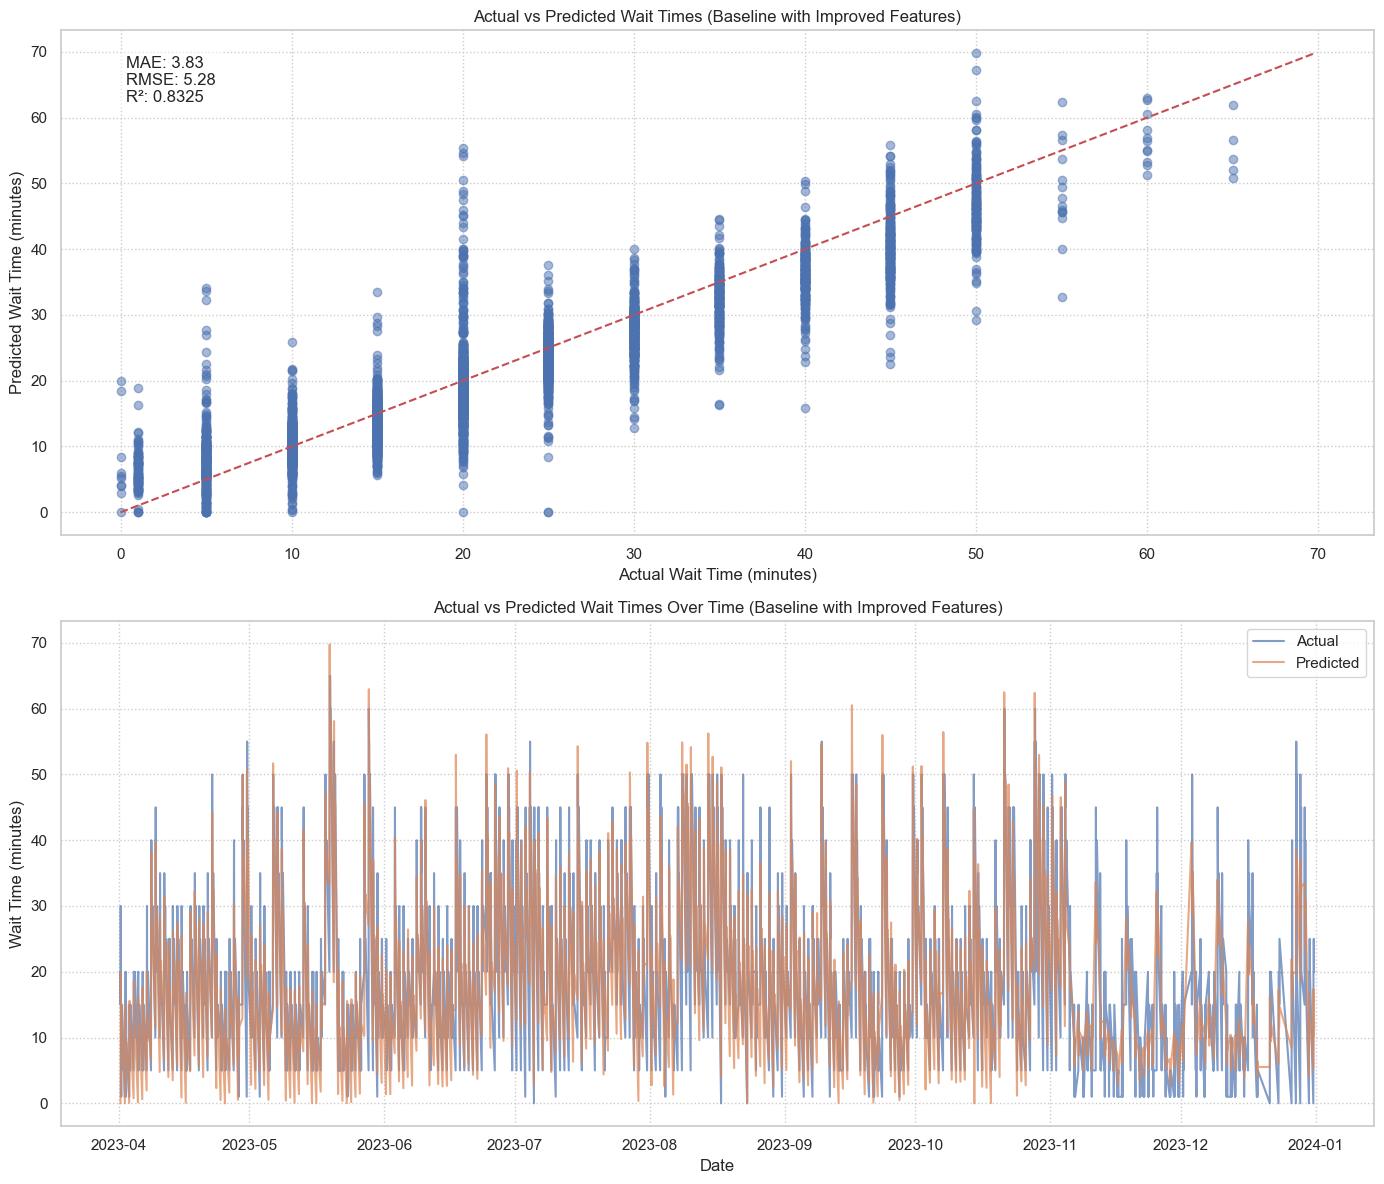

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


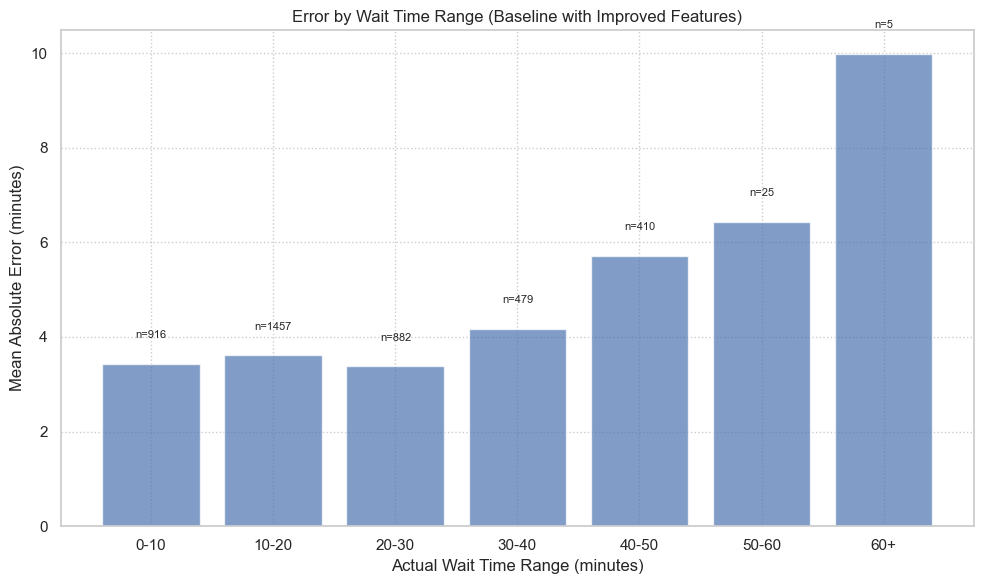

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


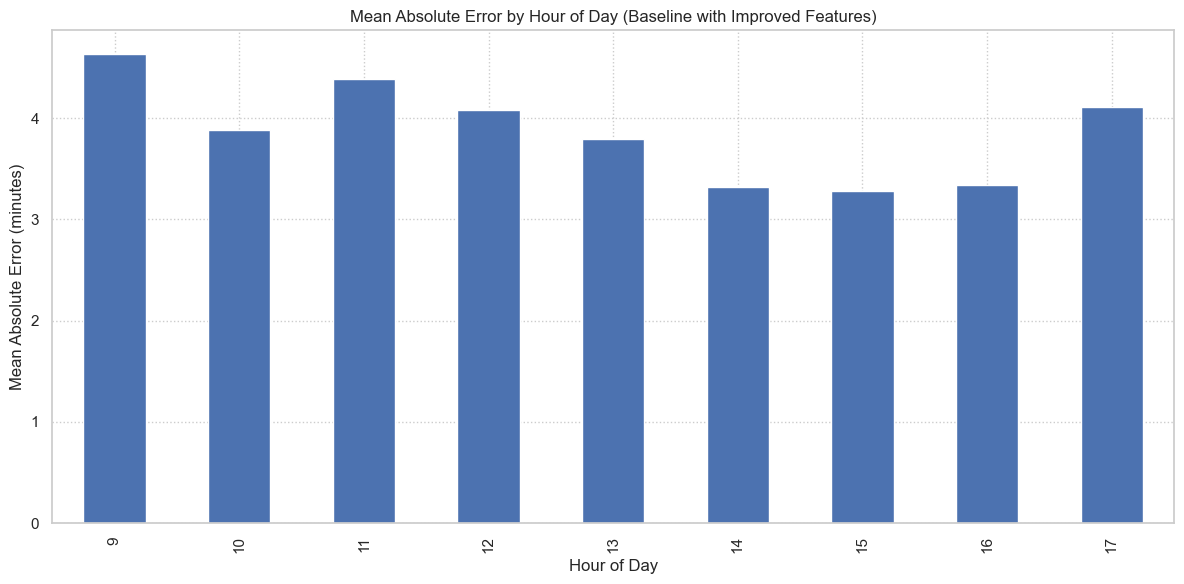

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


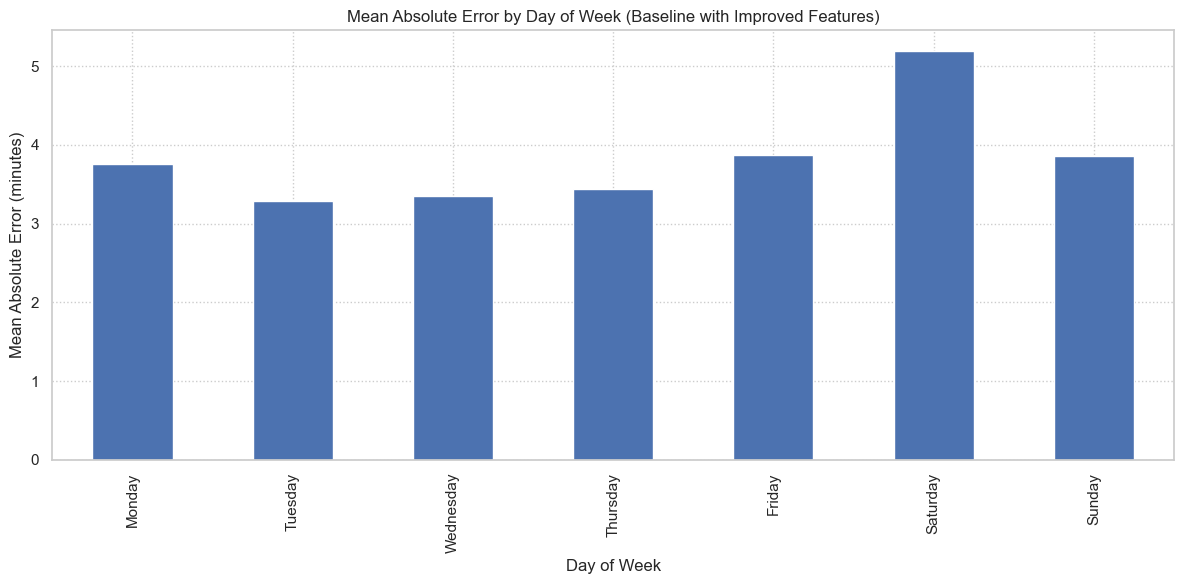


----- Step 6: Training gradient boosting model -----

Gradient Boosting Model Evaluation:
Mean Absolute Error (MAE): 3.29 minutes
Root Mean Squared Error (RMSE): 4.73 minutes
R² Score: 0.8655
Mean Absolute Percentage Error (MAPE): 30.95%
MAE for low wait times (<10 min): 3.70 minutes
MAE for medium wait times (10-40 min): 3.05 minutes
MAE for high wait times (>40 min): 4.65 minutes

Visualizing gradient boosting model results:


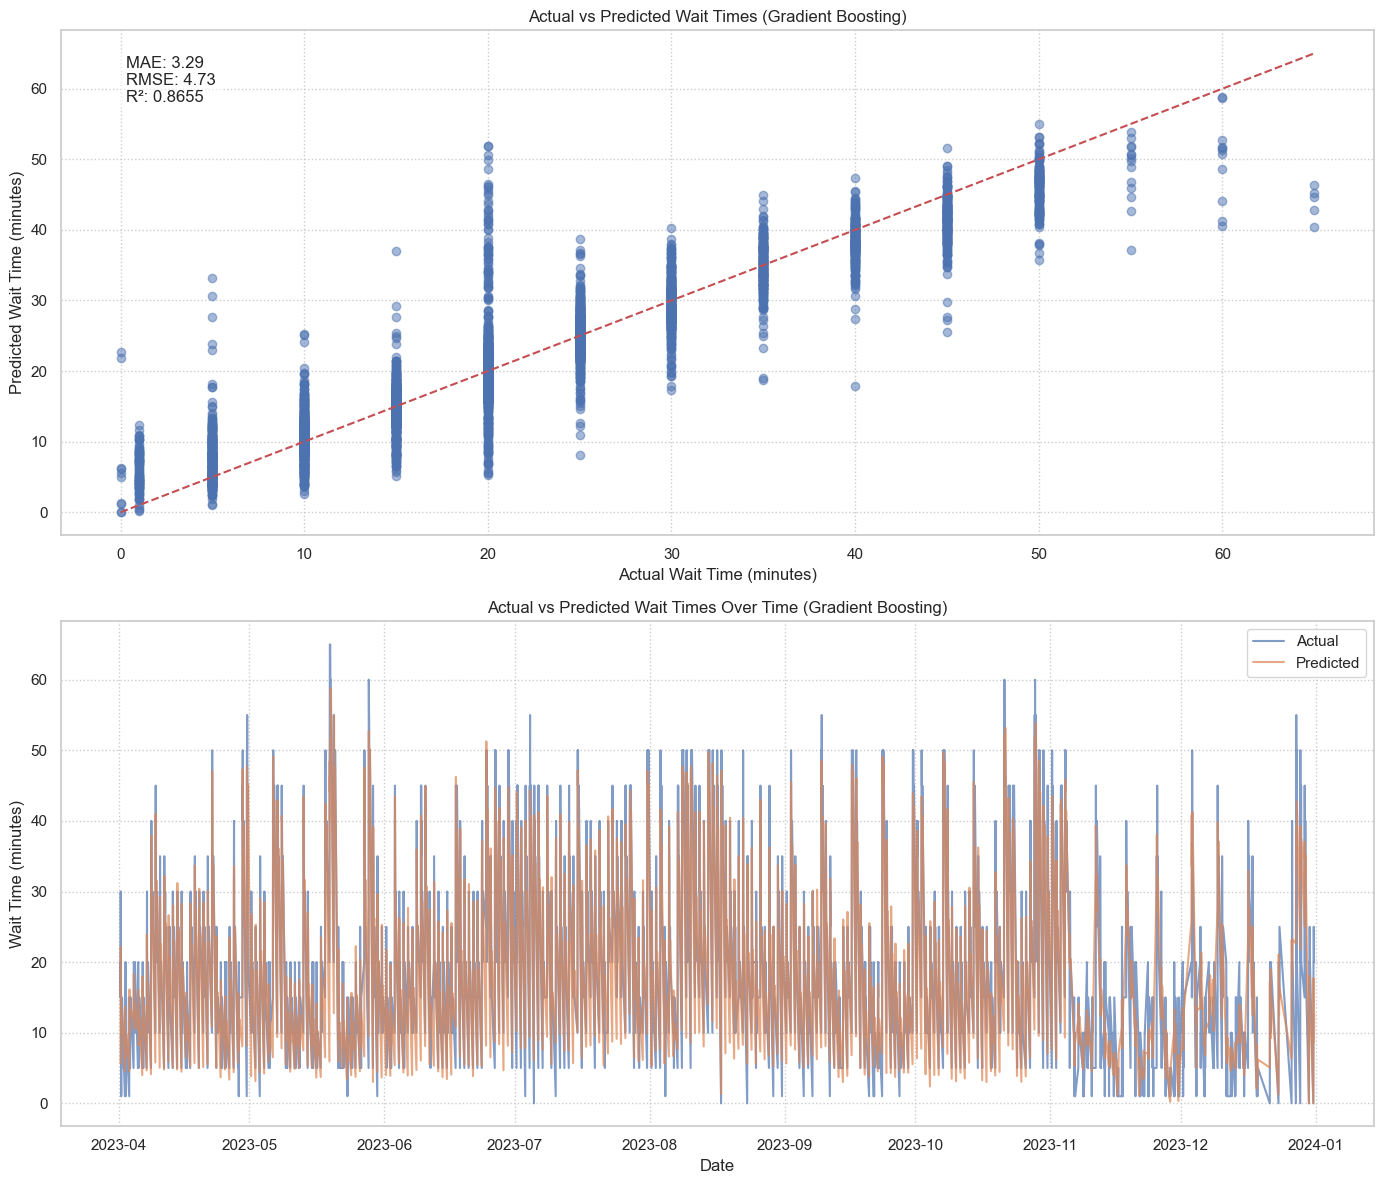

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


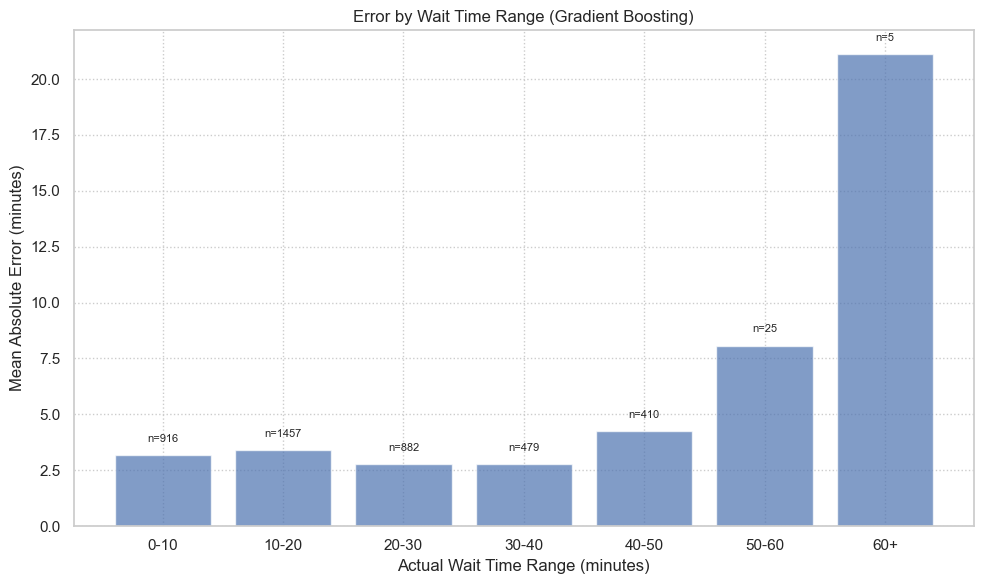

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


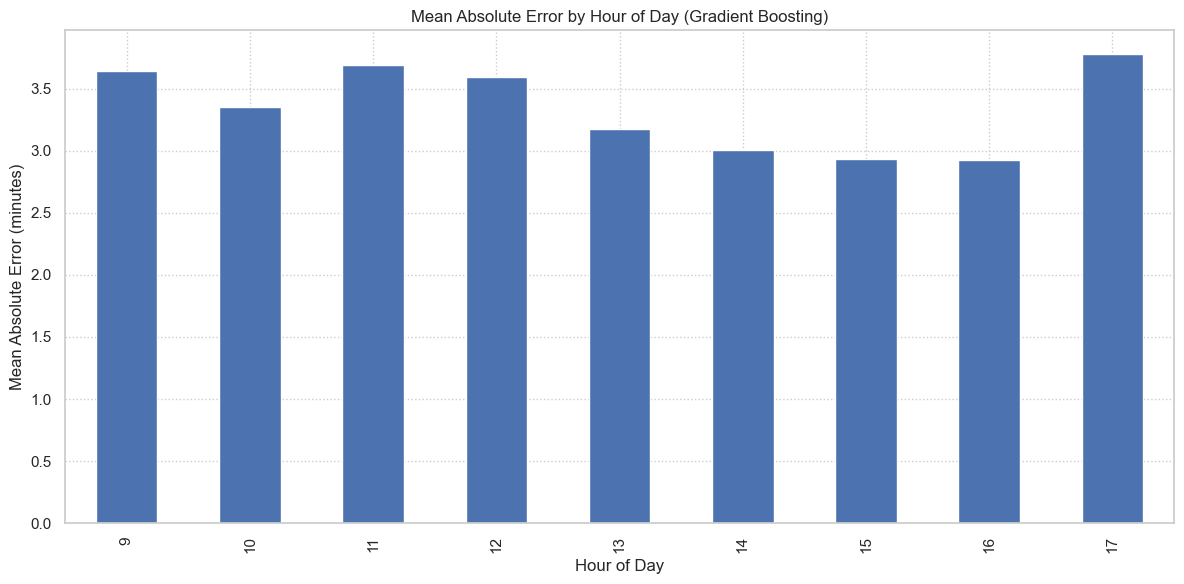

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


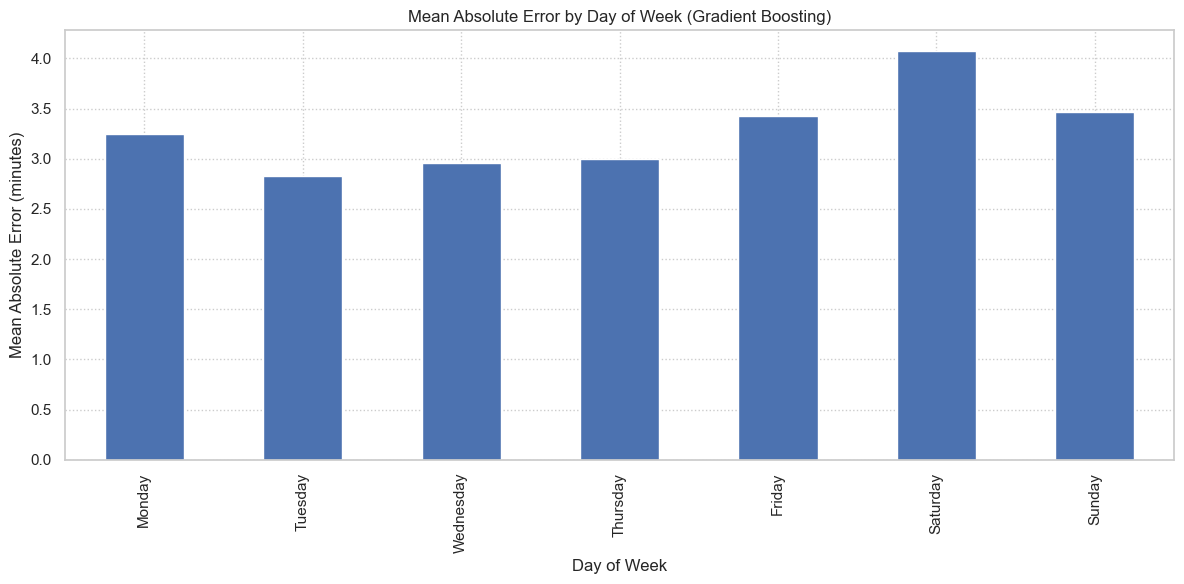


----- Step 7: Creating and applying peak correction model -----

Applying correction model to gradient boosting predictions:
Primary Model Metrics:
MAE: 3.29, RMSE: 4.73, R²: 0.8655, MAPE: 30.95%

Corrected Model Metrics:
MAE: 3.25, RMSE: 4.72, R²: 0.8659, MAPE: 30.41%

Improvement:
MAE: 0.04 (1.25%)
RMSE: 0.01 (0.16%)
R²: 0.0004 (0.05%)
MAPE: 0.54% (1.75%)

Low Wait (<10 min) MAE: 3.70 -> 3.60 (2.77% improvement)
High Wait (>40 min) MAE: 4.65 -> 4.24 (8.78% improvement)

Visualizing corrected model results:


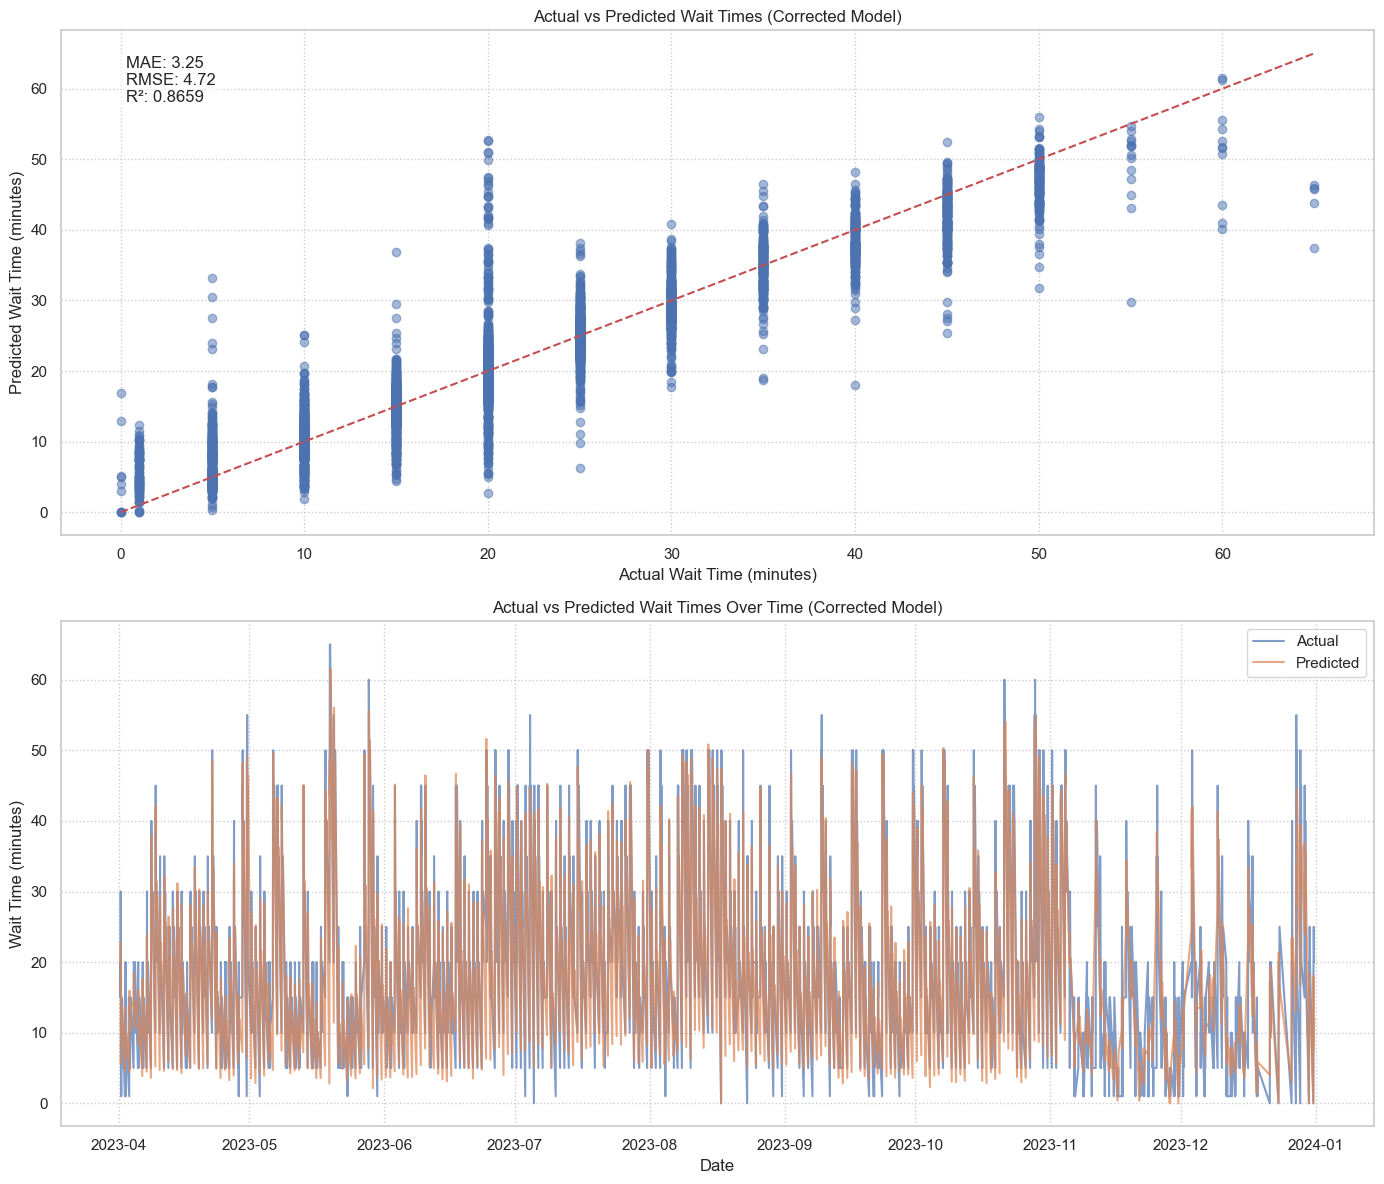

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


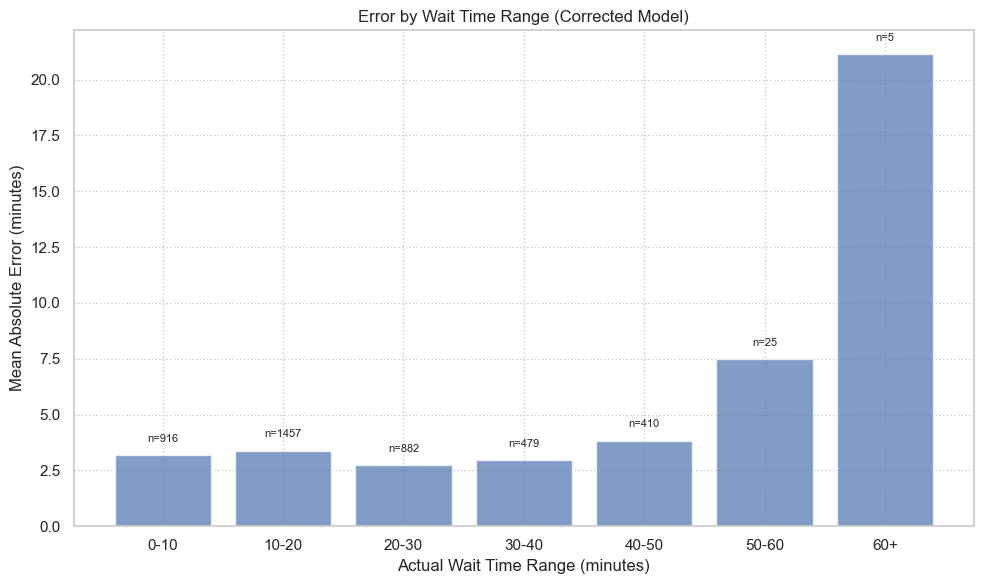

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


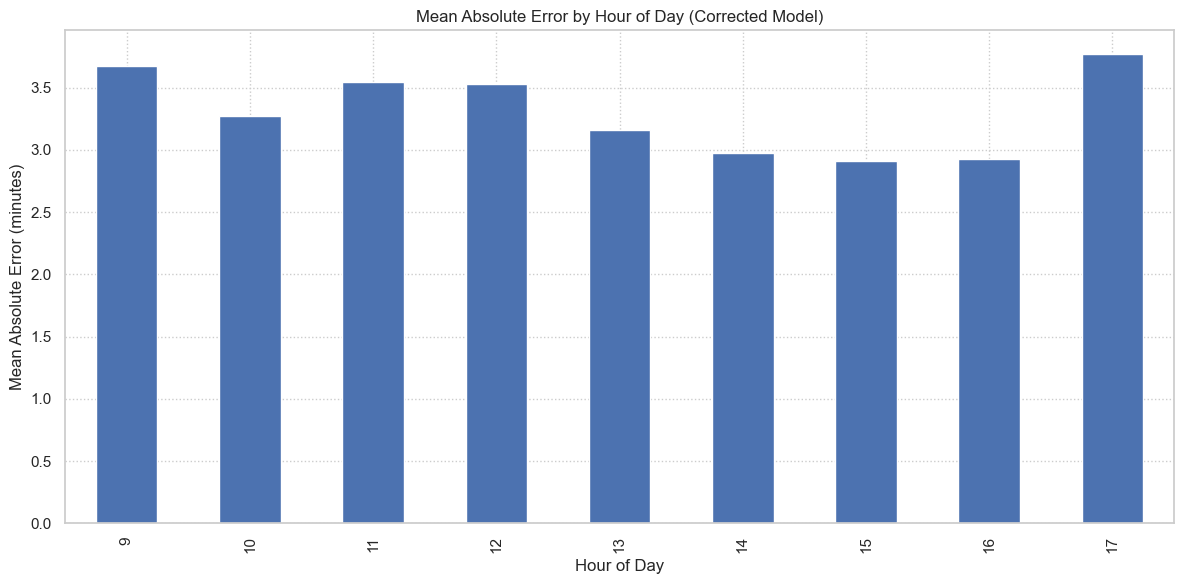

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


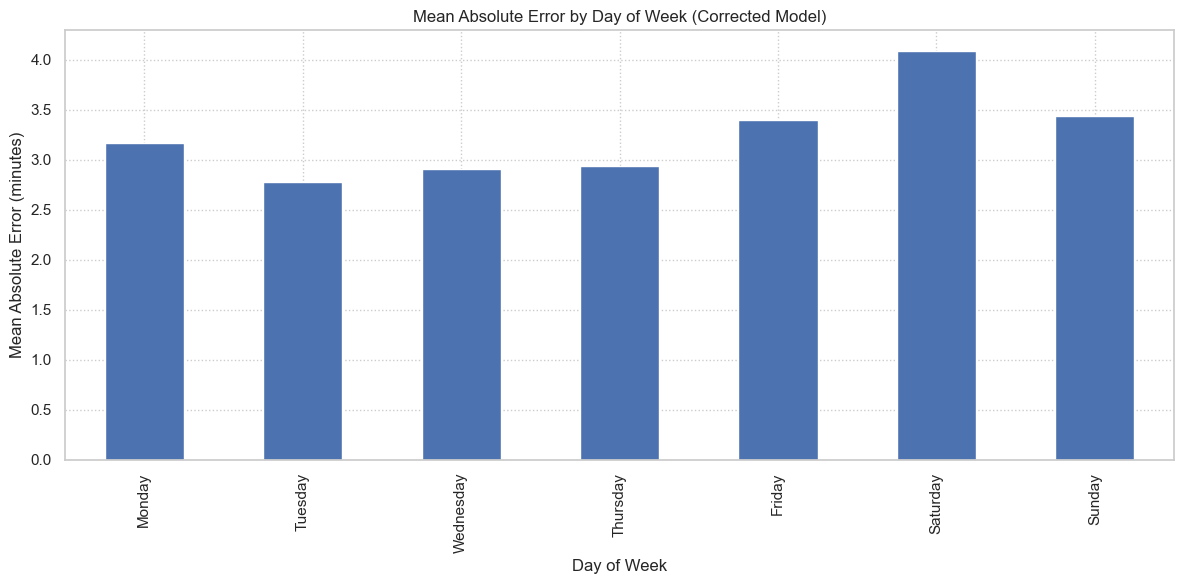


----- Step 8: Creating ensemble model -----
Training linear model...
Training random forest model...
Training gradient boosting model...
Training ensemble model...

Ensemble Model Evaluation:
Mean Absolute Error (MAE): 3.38 minutes
Root Mean Squared Error (RMSE): 4.81 minutes
R² Score: 0.8610
Mean Absolute Percentage Error (MAPE): 32.29%
MAE for low wait times (<10 min): 4.32 minutes
MAE for medium wait times (10-40 min): 3.01 minutes
MAE for high wait times (>40 min): 5.11 minutes

Visualizing ensemble model results:


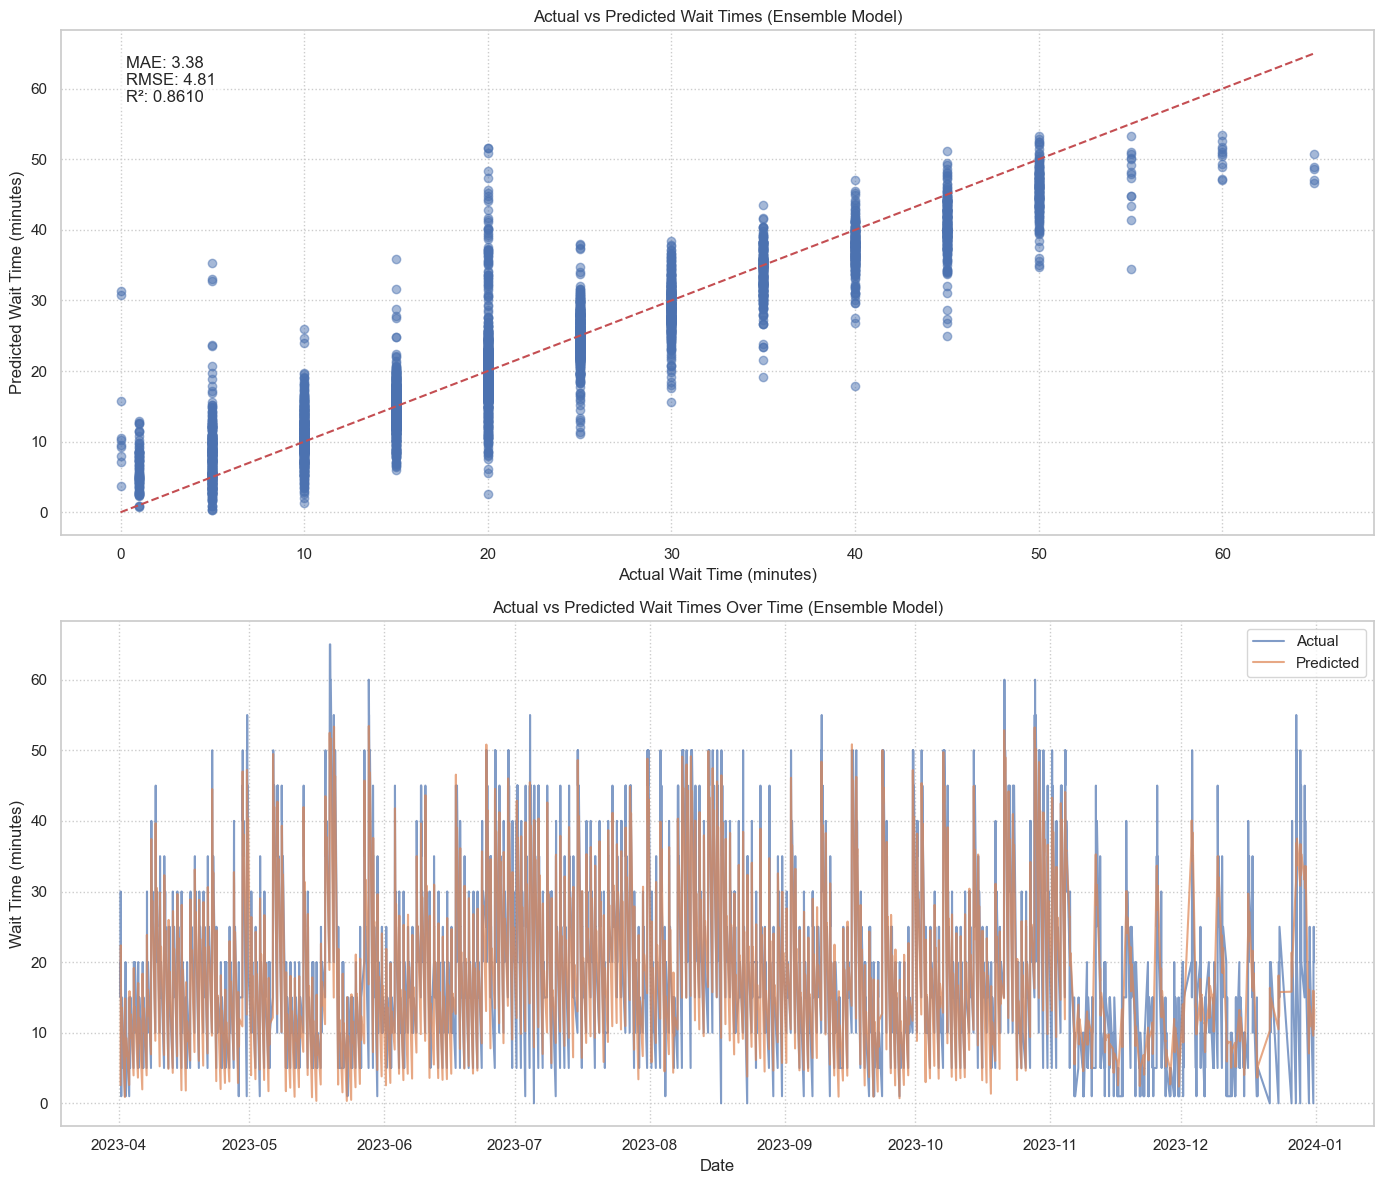

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


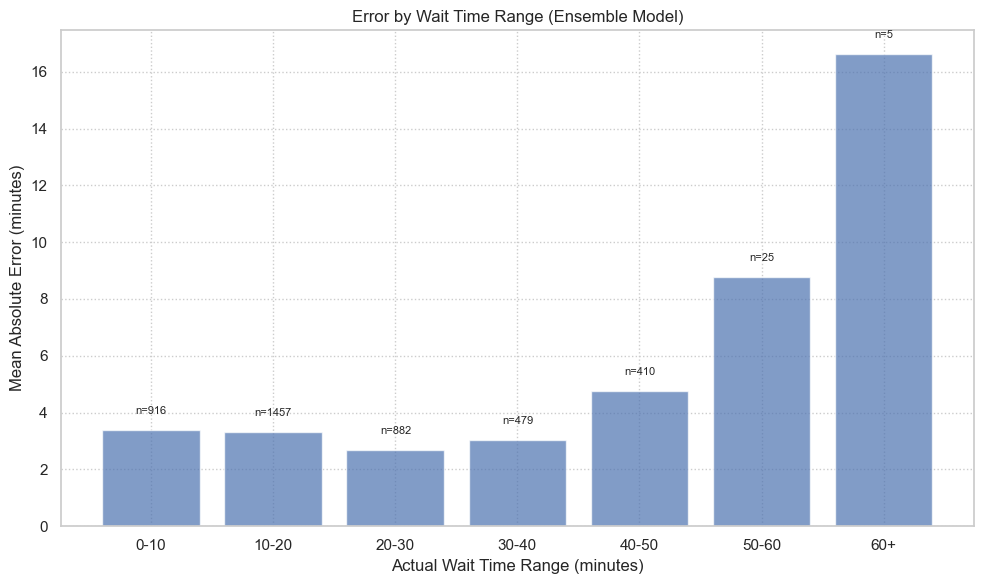

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


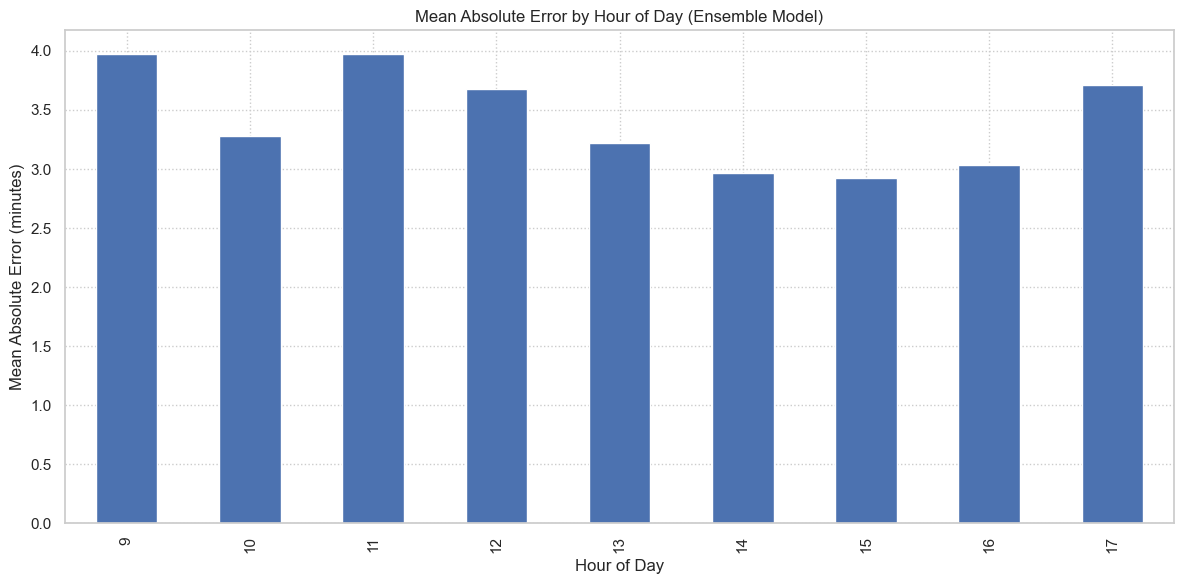

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


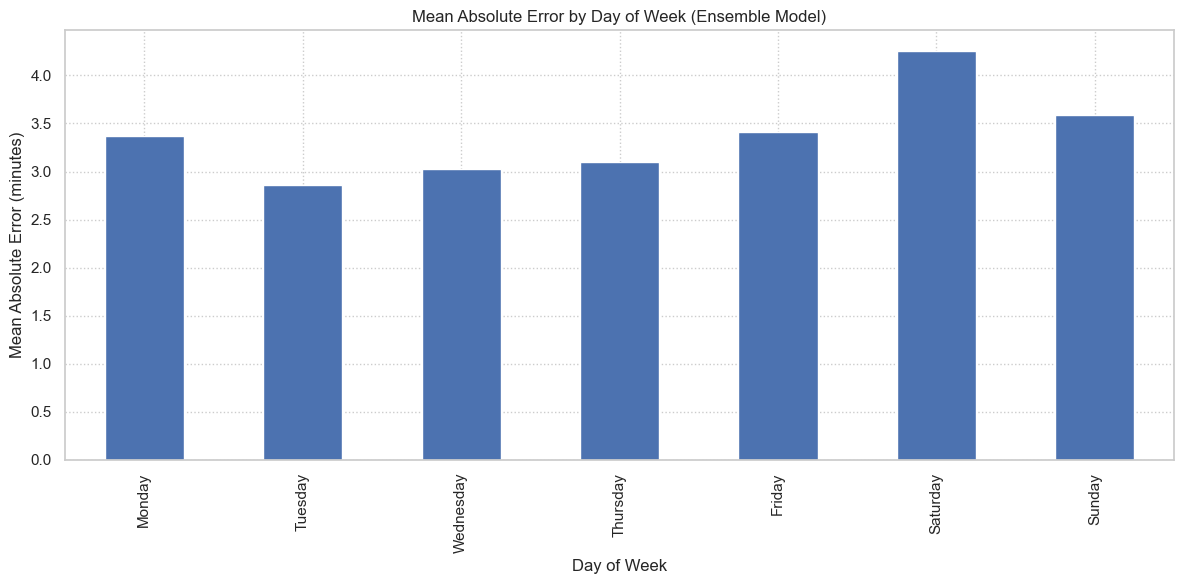

Traceback (most recent call last):
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\571732666.py", line 38, in <module>
    ride_results = run_optimal_wait_time_prediction(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\3151676217.py", line 116, in run_optimal_wait_time_prediction
    'MAE': mae_baseline,
           ^^^^^^^^^^^^
NameError: name 'mae_baseline' is not defined. Did you mean: 'model_baseline'?



----- Step 9: Comparing all models -----
Error analyzing silver star: name 'mae_baseline' is not defined


ANALYZING RIDE: POSEIDON

===== Running Optimized Wait Time Prediction for poseidon =====

----- Step 1: Loading and preprocessing data -----
Loaded data shape: (103081, 10)
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 593
Sample of zero wait time days: Index([2017-06-06, 2017-08-31, 2017-09-12, 2017-09-13, 2017-09-14, 2017-09-19,
       2017-09-20, 2017-10-06, 2017-10-08, 2017-10-23],
      dtype='object', name='timestamp')
Data shape after removing closed and zero wait days: (61038, 10)
Data shape after filtering to operating hours: (22148, 10)

----- Step 2: Creating advanced features -----
Created time-based features
Created attendance features
Enhanc

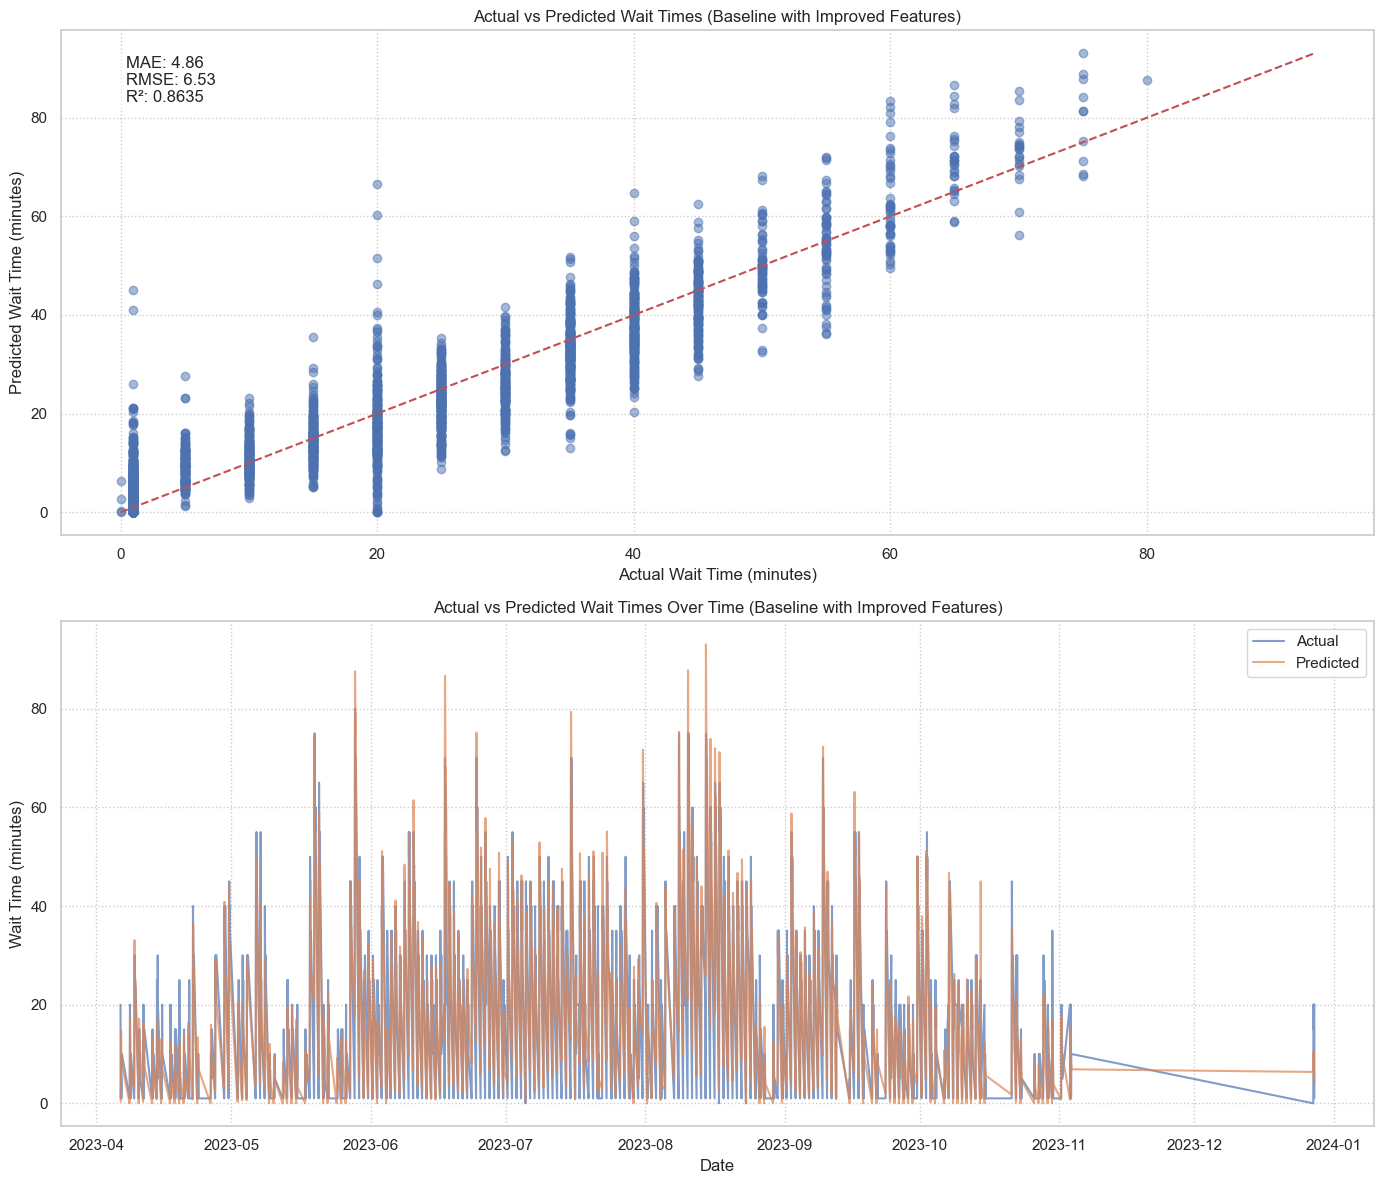

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


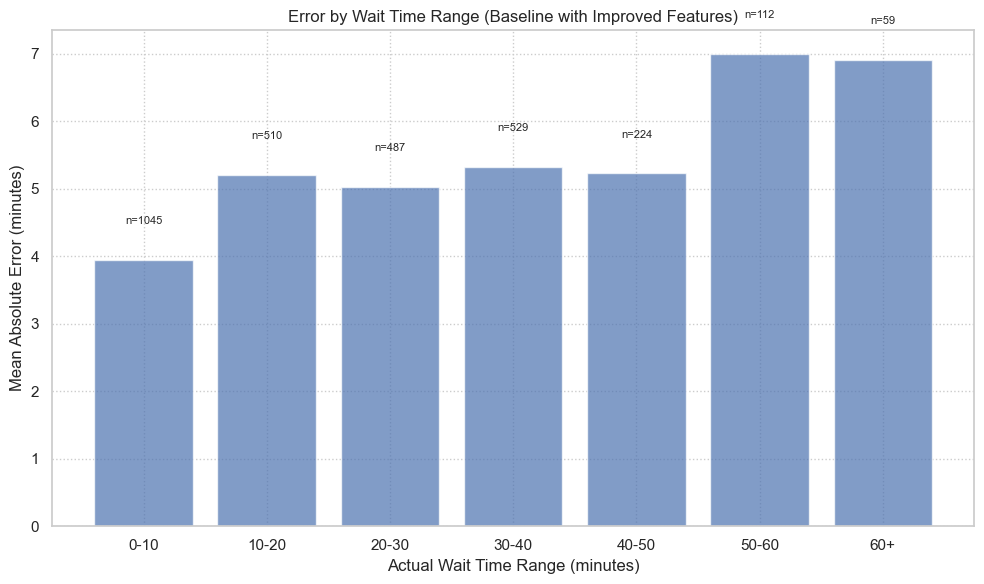

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


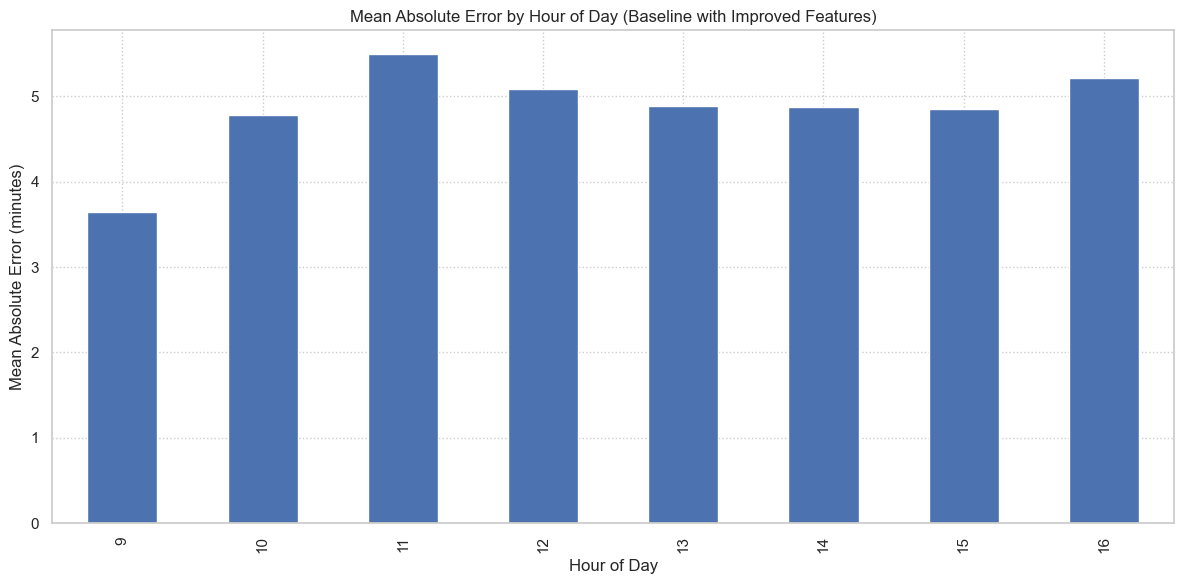

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


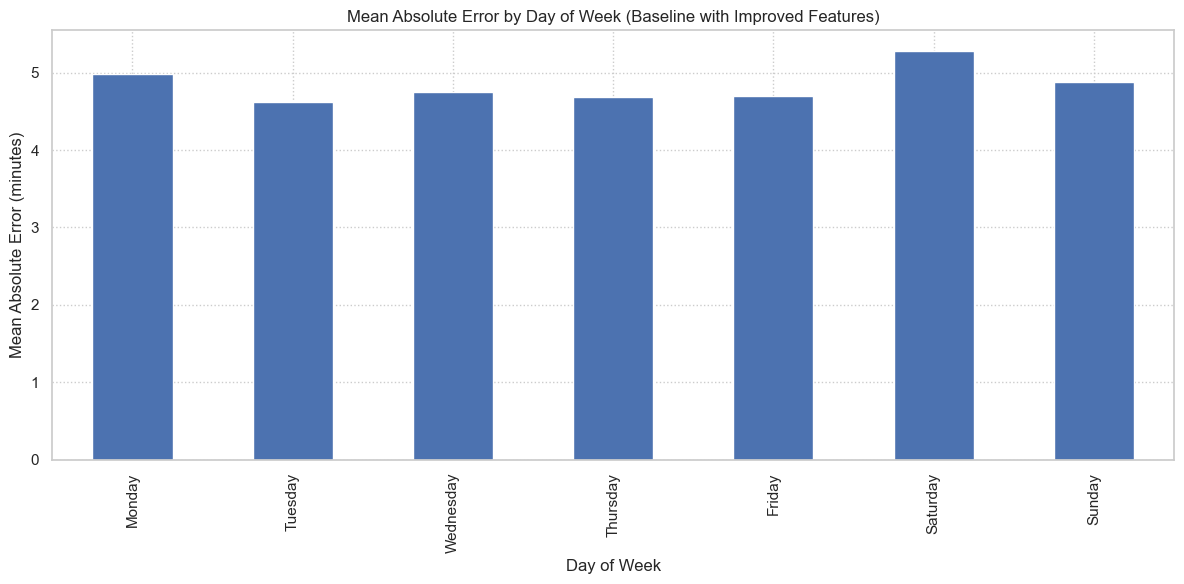


----- Step 6: Training gradient boosting model -----

Gradient Boosting Model Evaluation:
Mean Absolute Error (MAE): 3.95 minutes
Root Mean Squared Error (RMSE): 5.49 minutes
R² Score: 0.9034
Mean Absolute Percentage Error (MAPE): 72.97%
MAE for low wait times (<10 min): 2.82 minutes
MAE for medium wait times (10-40 min): 4.36 minutes
MAE for high wait times (>40 min): 4.48 minutes

Visualizing gradient boosting model results:


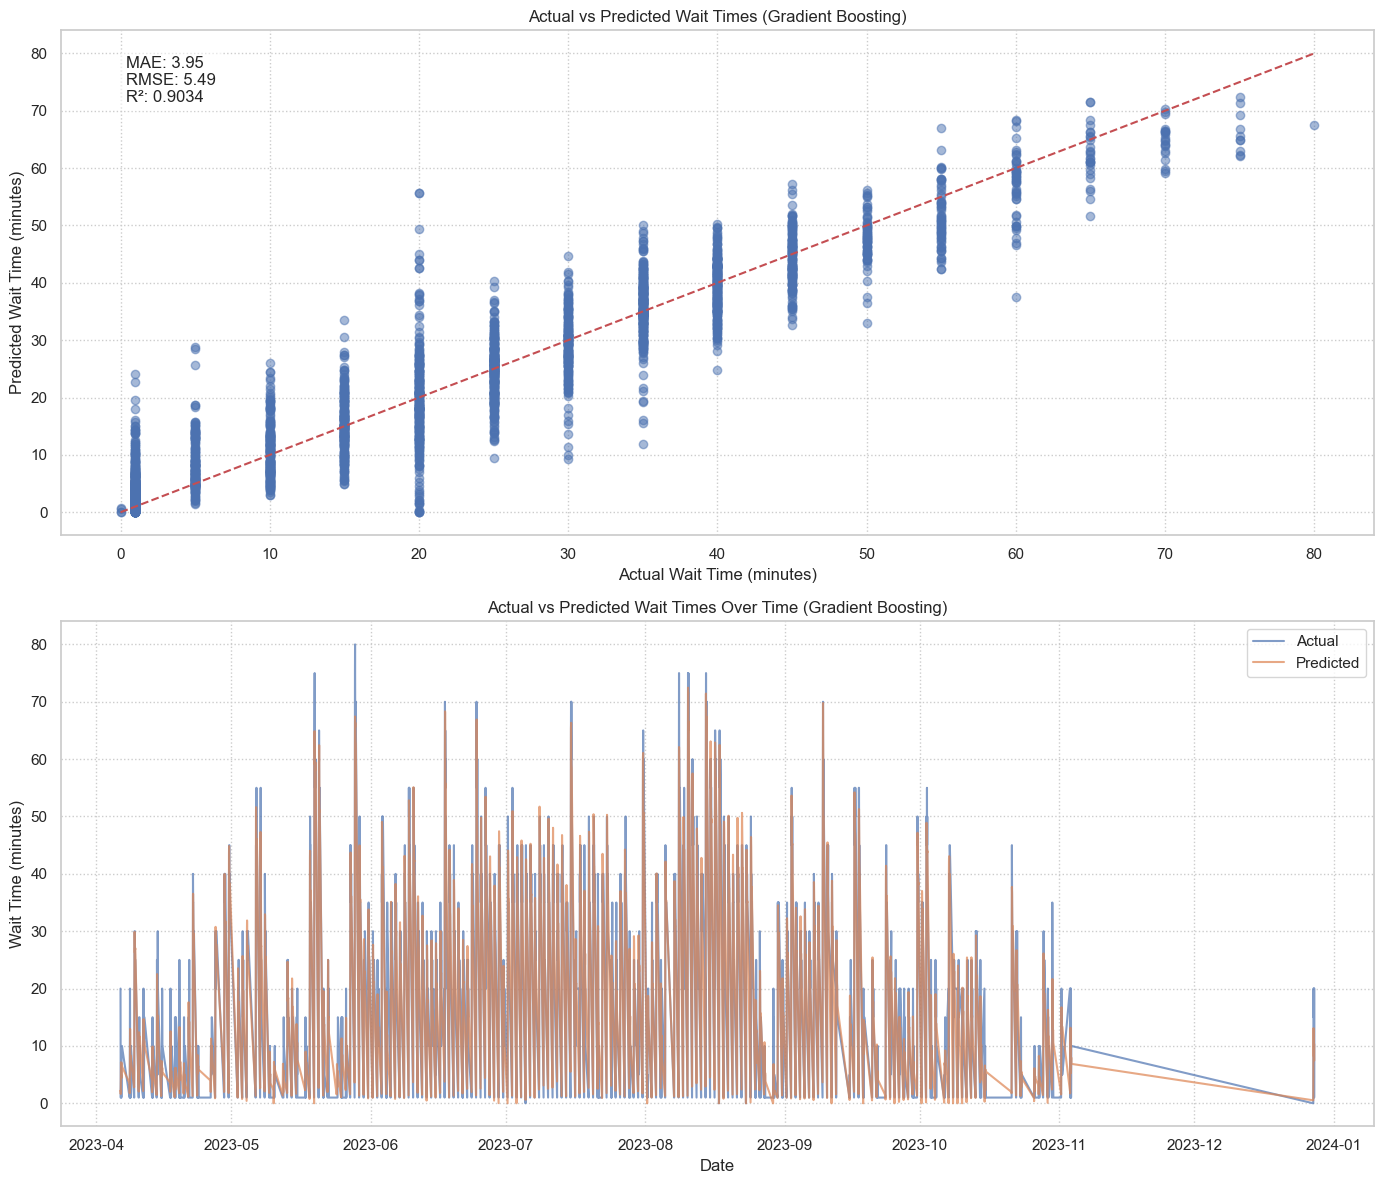

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


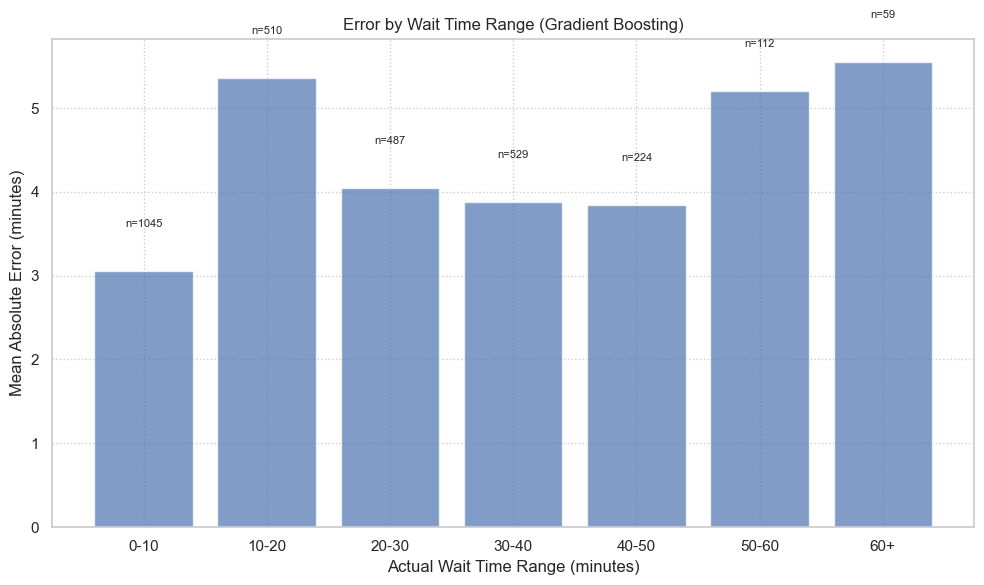

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


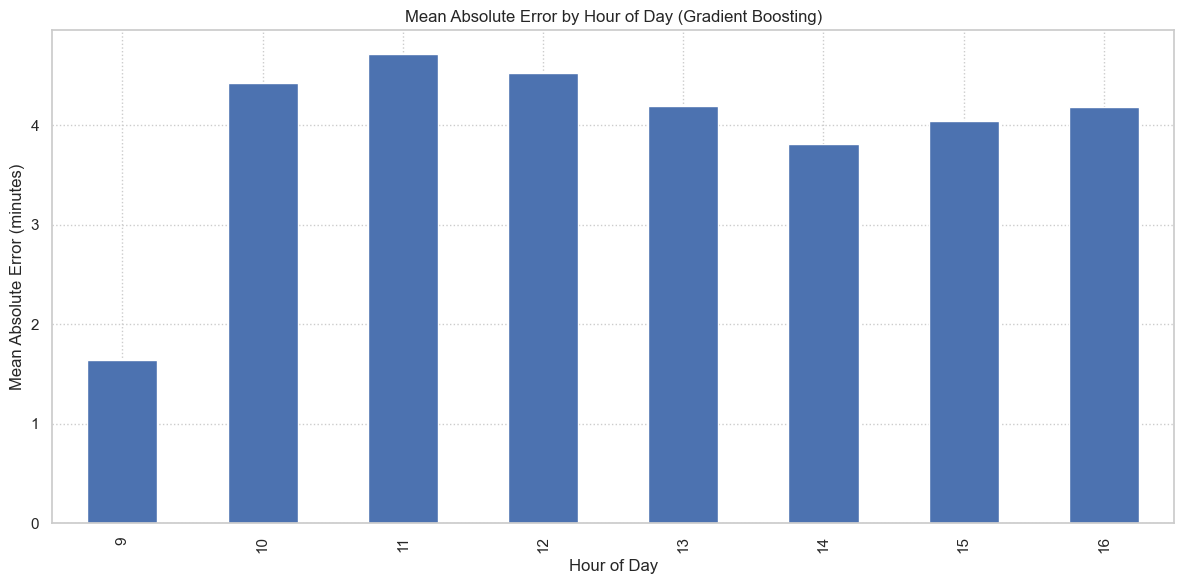

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


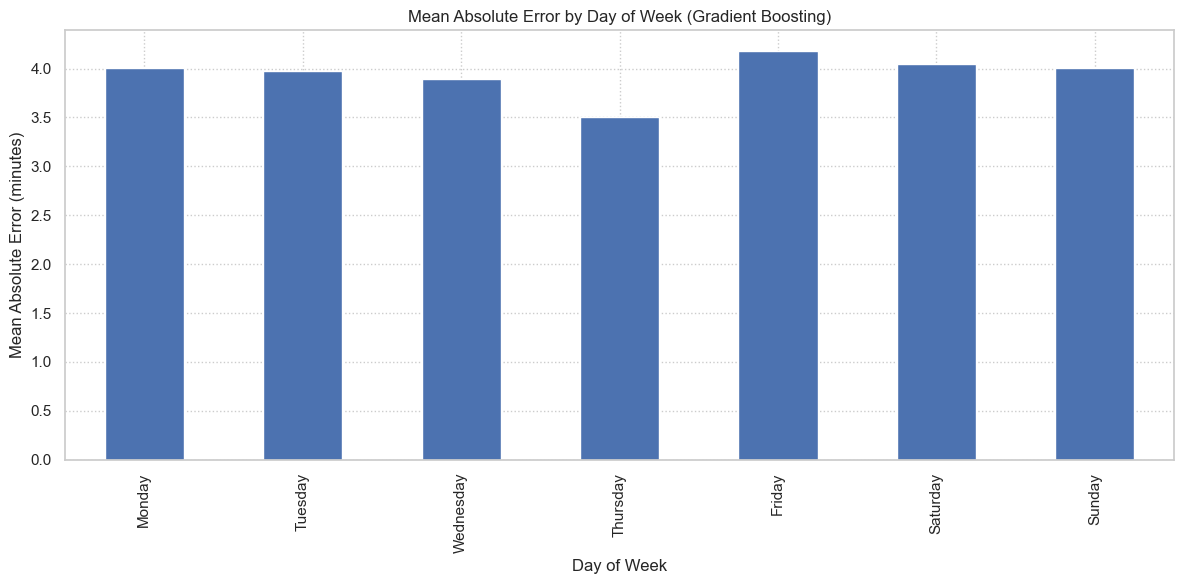


----- Step 7: Creating and applying peak correction model -----

Applying correction model to gradient boosting predictions:
Primary Model Metrics:
MAE: 3.95, RMSE: 5.49, R²: 0.9034, MAPE: 72.97%

Corrected Model Metrics:
MAE: 3.92, RMSE: 5.53, R²: 0.9019, MAPE: 67.67%

Improvement:
MAE: 0.02 (0.58%)
RMSE: -0.04 (-0.74%)
R²: -0.0014 (-0.16%)
MAPE: 5.30% (7.27%)

Low Wait (<10 min) MAE: 2.82 -> 2.61 (7.33% improvement)
High Wait (>40 min) MAE: 4.48 -> 4.65 (-3.81% improvement)

Visualizing corrected model results:


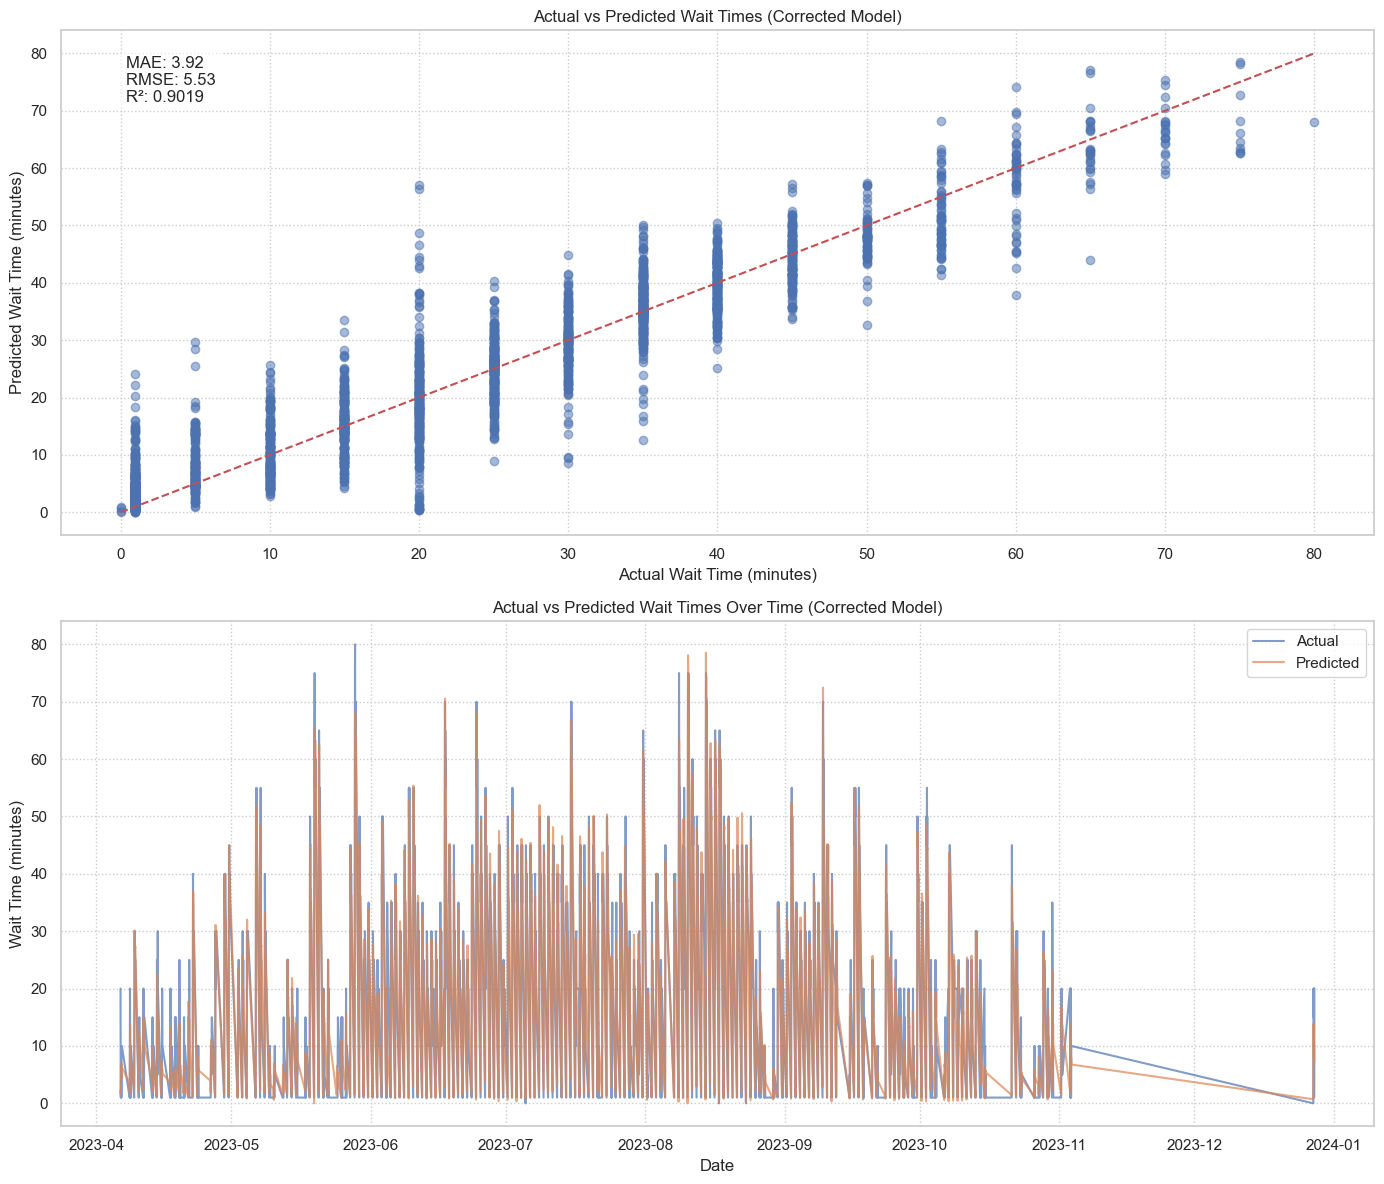

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


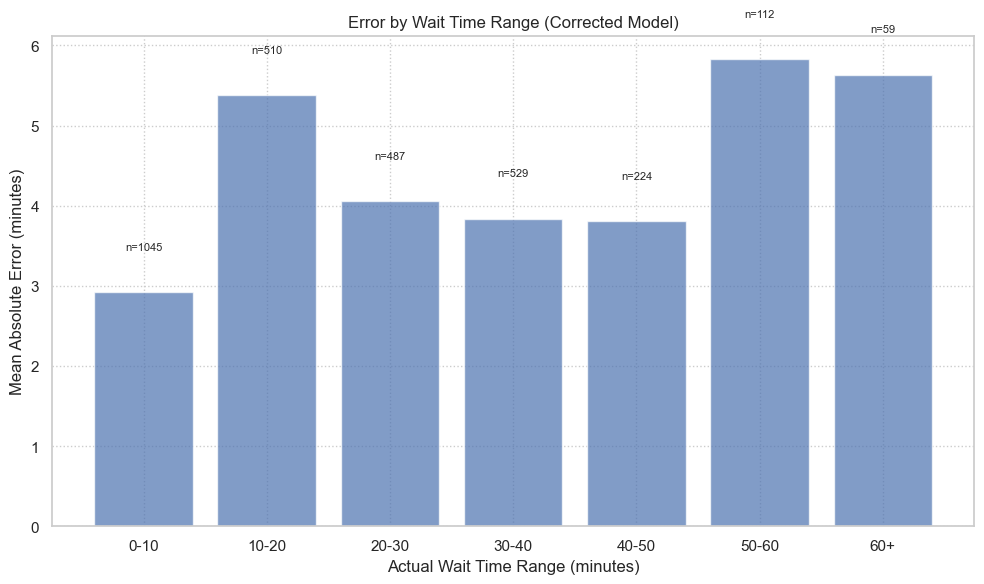

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


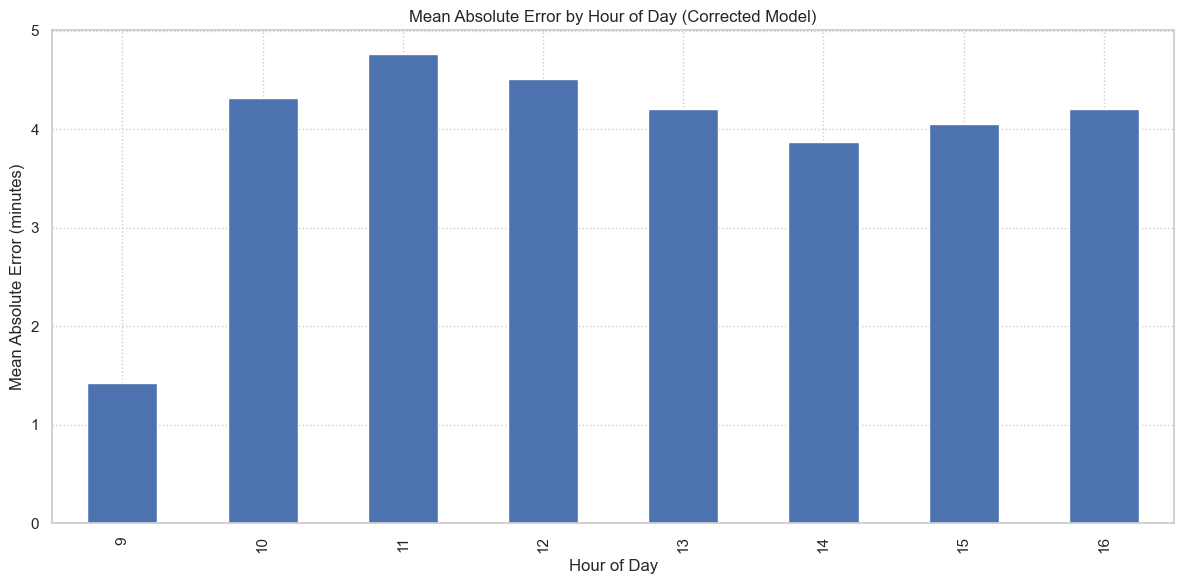

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


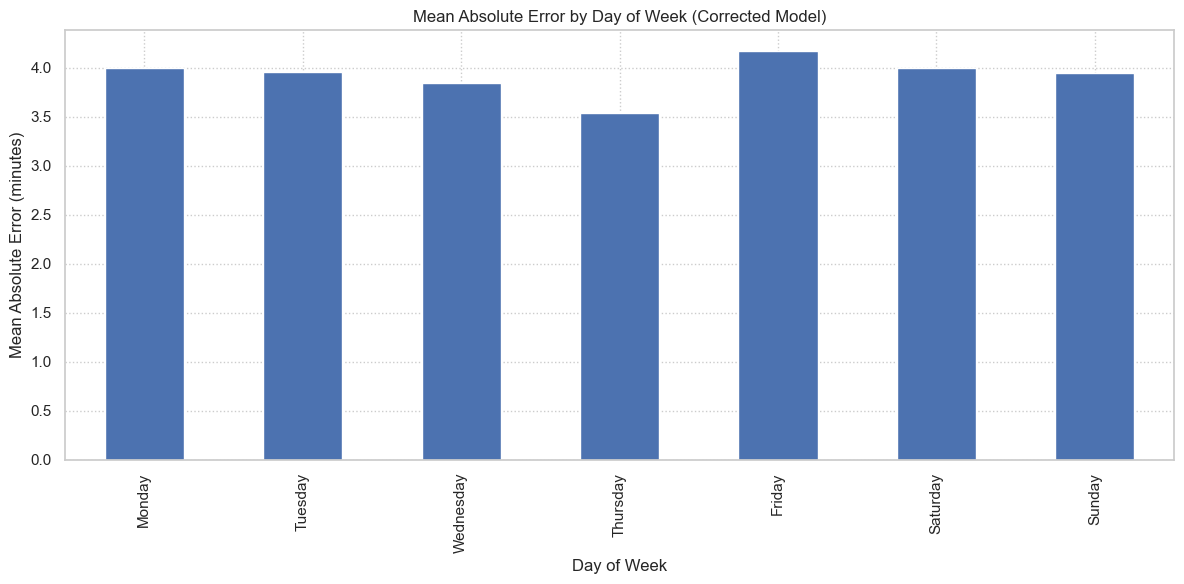


----- Step 8: Creating ensemble model -----
Training linear model...
Training random forest model...
Training gradient boosting model...
Training ensemble model...

Ensemble Model Evaluation:
Mean Absolute Error (MAE): 4.19 minutes
Root Mean Squared Error (RMSE): 5.63 minutes
R² Score: 0.8984
Mean Absolute Percentage Error (MAPE): 105.42%
MAE for low wait times (<10 min): 4.13 minutes
MAE for medium wait times (10-40 min): 4.09 minutes
MAE for high wait times (>40 min): 4.75 minutes

Visualizing ensemble model results:


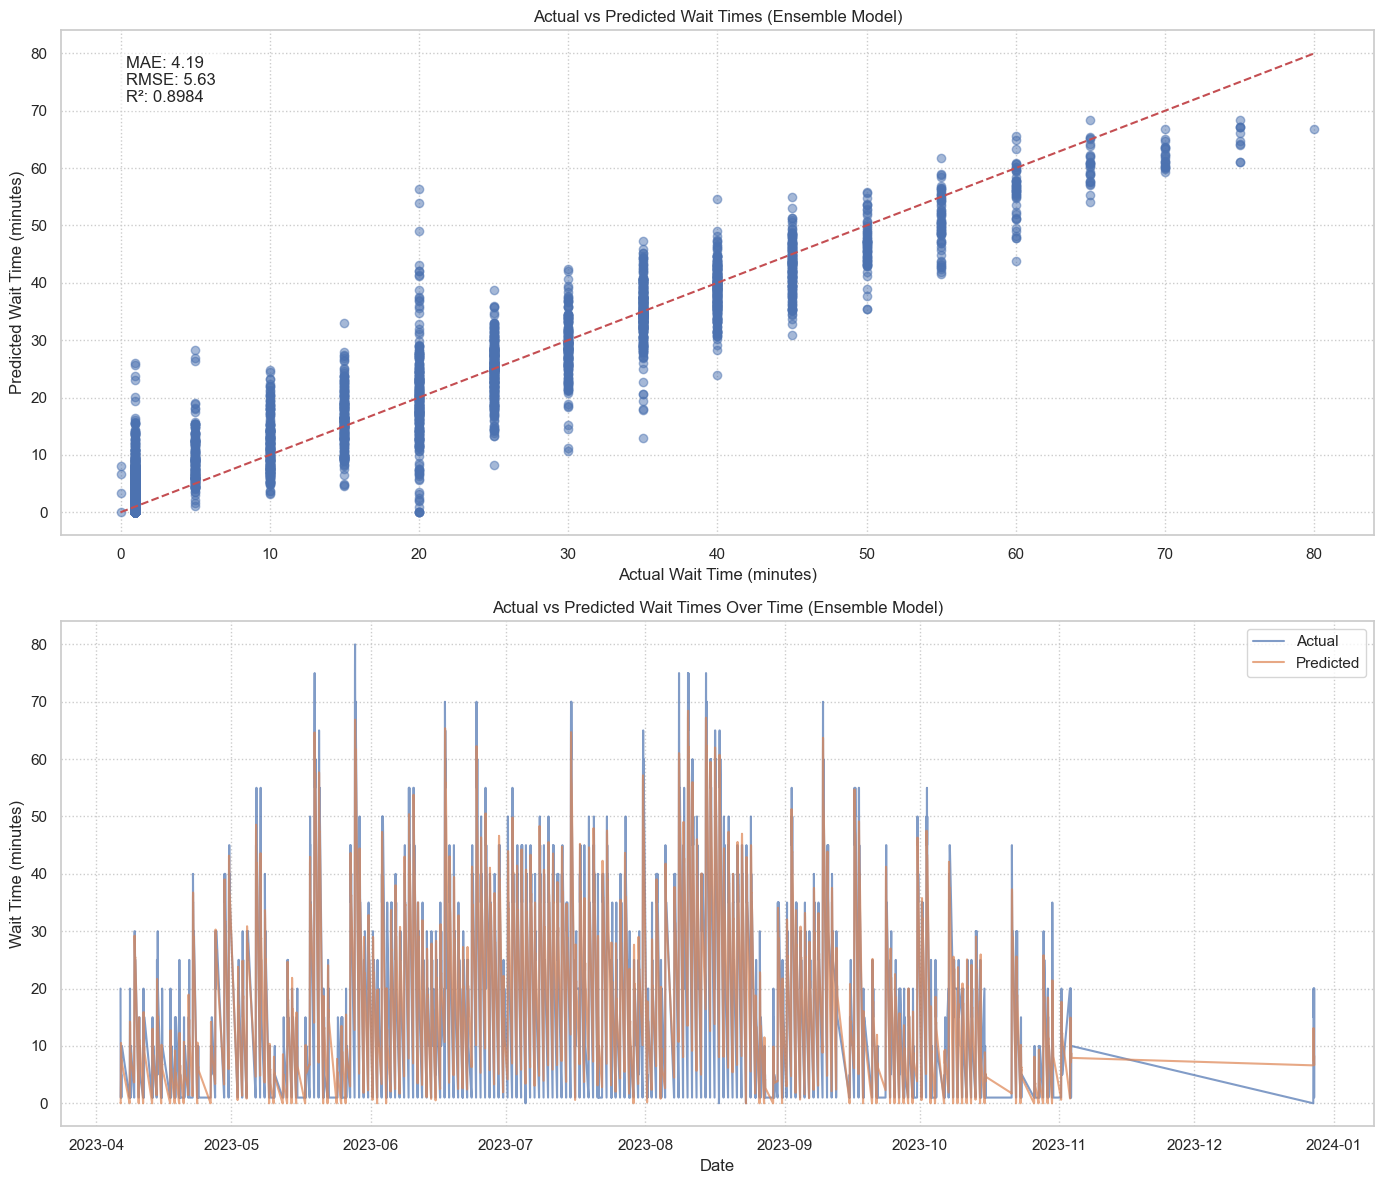

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


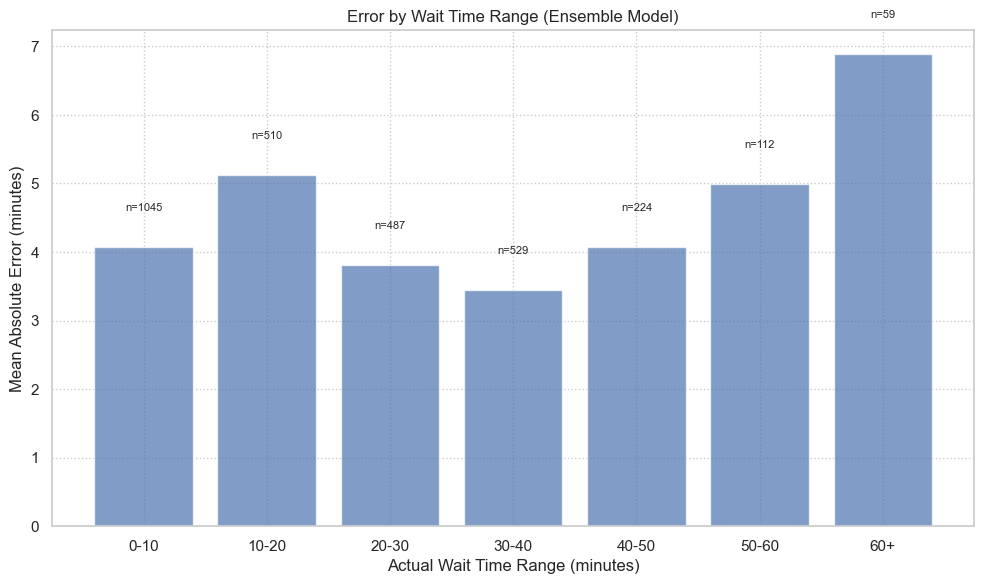

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


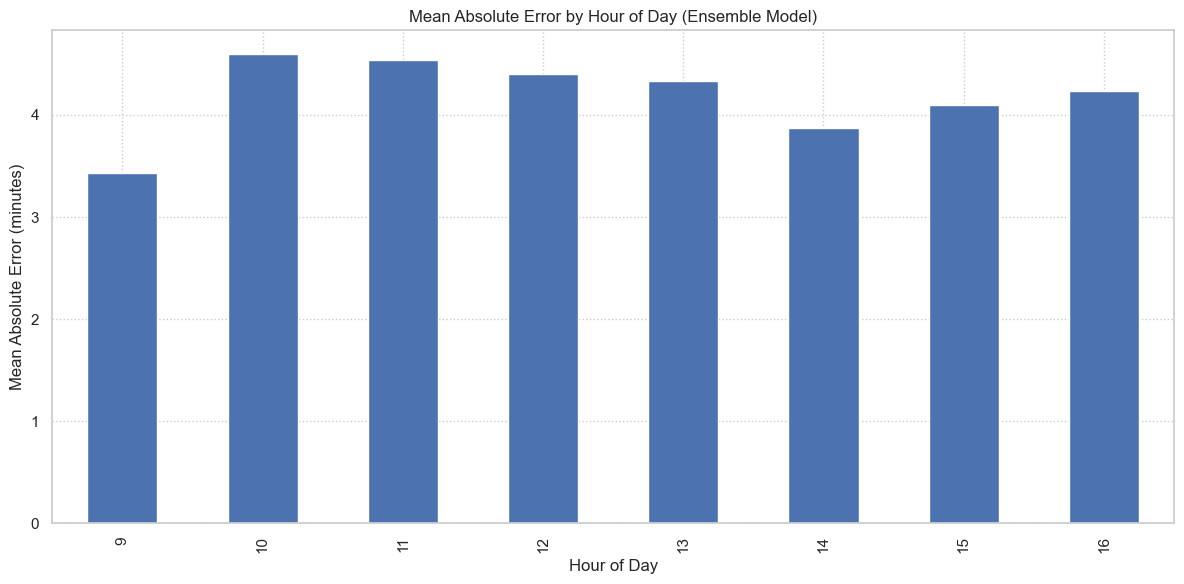

C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


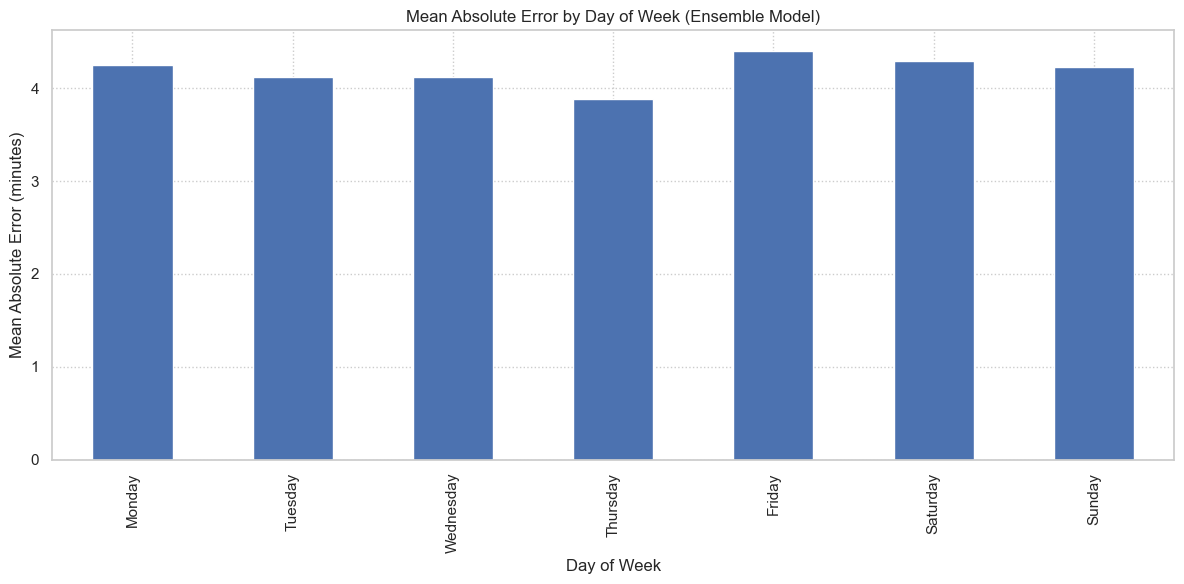


----- Step 9: Comparing all models -----
Error analyzing poseidon: name 'mae_baseline' is not defined


FINAL SUMMARY
No ride analyses completed successfully.


Traceback (most recent call last):
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\571732666.py", line 38, in <module>
    ride_results = run_optimal_wait_time_prediction(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_28036\3151676217.py", line 116, in run_optimal_wait_time_prediction
    'MAE': mae_baseline,
           ^^^^^^^^^^^^
NameError: name 'mae_baseline' is not defined. Did you mean: 'model_baseline'?


In [59]:
# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Set up special events dates (example - adjust for your actual data)
# Define some approximate special events for demonstration
# In production, you would use actual known dates
current_year = 2023
special_events = {
    'summer_vacation': [f"{current_year}-07-{day:02d}" for day in range(1, 32)] + 
                       [f"{current_year}-08-{day:02d}" for day in range(1, 32)],
    'spring_break': [f"{current_year}-04-{day:02d}" for day in range(10, 21)],
    'major_holidays': [
        f"{current_year}-01-01",  # New Year
        f"{current_year}-04-14",  # Easter (approximation)
        f"{current_year}-05-01",  # Labor Day
        f"{current_year}-12-24",  # Christmas Eve
        f"{current_year}-12-25",  # Christmas
        f"{current_year}-12-26",  # Boxing Day
    ]
}

# Run the complete pipeline
if __name__ == "__main__":
    # Define parameters
    data_path = "../data/processed/ep/merged_with_holidays.parquet"  # Update with your actual path
    ride_names = ["silver star", "poseidon"]  # Update with your rides of interest
    test_year = 2023  # Year to use for testing
    
    # Process each ride
    results = {}
    for ride_name in ride_names:
        print(f"\n\n{'='*80}")
        print(f"ANALYZING RIDE: {ride_name.upper()}")
        print(f"{'='*80}\n")
        
        try:
            ride_results = run_optimal_wait_time_prediction(
                file_path=data_path,
                ride_name=ride_name,
                test_year=test_year,
                special_events=special_events
            )
            
            results[ride_name] = ride_results
            
            print(f"\nSuccessfully completed analysis for {ride_name}")
            print(f"Best model MAE: {ride_results['results_comparison'].loc[ride_results['results_comparison']['MAE'].idxmin(), 'MAE']:.2f}")
            
        except Exception as e:
            print(f"Error analyzing {ride_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Print final summary
    print("\n\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)
    
    # Check if we have any results to summarize
    if not results:
        print("No ride analyses completed successfully.")
    else:
        summary_data = []
        for ride_name, ride_results in results.items():
            if 'results_comparison' in ride_results and not ride_results['results_comparison'].empty:
                best_model = ride_results['results_comparison']['MAE'].idxmin()
                best_mae = ride_results['results_comparison'].loc[best_model, 'MAE']
                best_rmse = ride_results['results_comparison'].loc[best_model, 'RMSE']
                best_r2 = ride_results['results_comparison'].loc[best_model, 'R²']
                
                baseline_mae = ride_results['results_comparison'].loc['Baseline', 'MAE']
                improvement = (baseline_mae - best_mae) / baseline_mae * 100
                
                summary_data.append({
                    'Ride': ride_name,
                    'Best Model': best_model,
                    'MAE': best_mae,
                    'RMSE': best_rmse,
                    'R²': best_r2,
                    'Improvement (%)': improvement
                })
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            print("\nBest model performance for each ride:")
            print(summary_df)
            
            # Visualize improvement across rides
            if len(summary_df) > 0:
                plt.figure(figsize=(12, 6))
                
                x = np.arange(len(summary_df))
                width = 0.35
                
                baseline_maes = []
                for ride in summary_df['Ride']:
                    if ride in results and 'results_comparison' in results[ride]:
                        try:
                            baseline_maes.append(results[ride]['results_comparison'].loc['Baseline', 'MAE'])
                        except:
                            baseline_maes.append(np.nan)
                
                if len(baseline_maes) == len(summary_df):
                    plt.bar(x - width/2, baseline_maes, width, label='Baseline', color='salmon')
                    plt.bar(x + width/2, summary_df['MAE'], width, label='Best Model', color='skyblue')
                    
                    plt.xlabel('Ride')
                    plt.ylabel('Mean Absolute Error (minutes)')
                    plt.title('Model Performance Comparison Across Rides')
                    plt.xticks(x, summary_df['Ride'])
                    plt.legend()
                    
                    # Add improvement percentage text
                    for i, row in summary_df.iterrows():
                        plt.text(i, max(baseline_maes[i], row['MAE']) + 0.5, 
                                f"{row['Improvement (%)']:.1f}%", 
                                ha='center', va='bottom',
                                color='green',
                                fontweight='bold')
                    
                    plt.tight_layout()
                    plt.show()
                else:
                    print("Cannot create visualization - baseline MAE data missing")
            else:
                print("Cannot create visualization - no summary data available")
        else:
            print("No ride analyses completed successfully.")